In [33]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE

In [5]:
from ucimlrepo import fetch_ucirepo
# fetch dataset
wine_quality = fetch_ucirepo(id=186)
# data (as pandas dataframes)
X = wine_quality.data.features
y = wine_quality.data.targets
# metadata
print(wine_quality.metadata)
# variable information
print(wine_quality.variables)

{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'title': 'Modeling wine preferences by data mining from physicoc

# Section A
Data Exploration & Visualization

Distribution after SMOTE:
quality_category
Normal       6053
Poor         6053
Excellent    6053
Name: count, dtype: int64


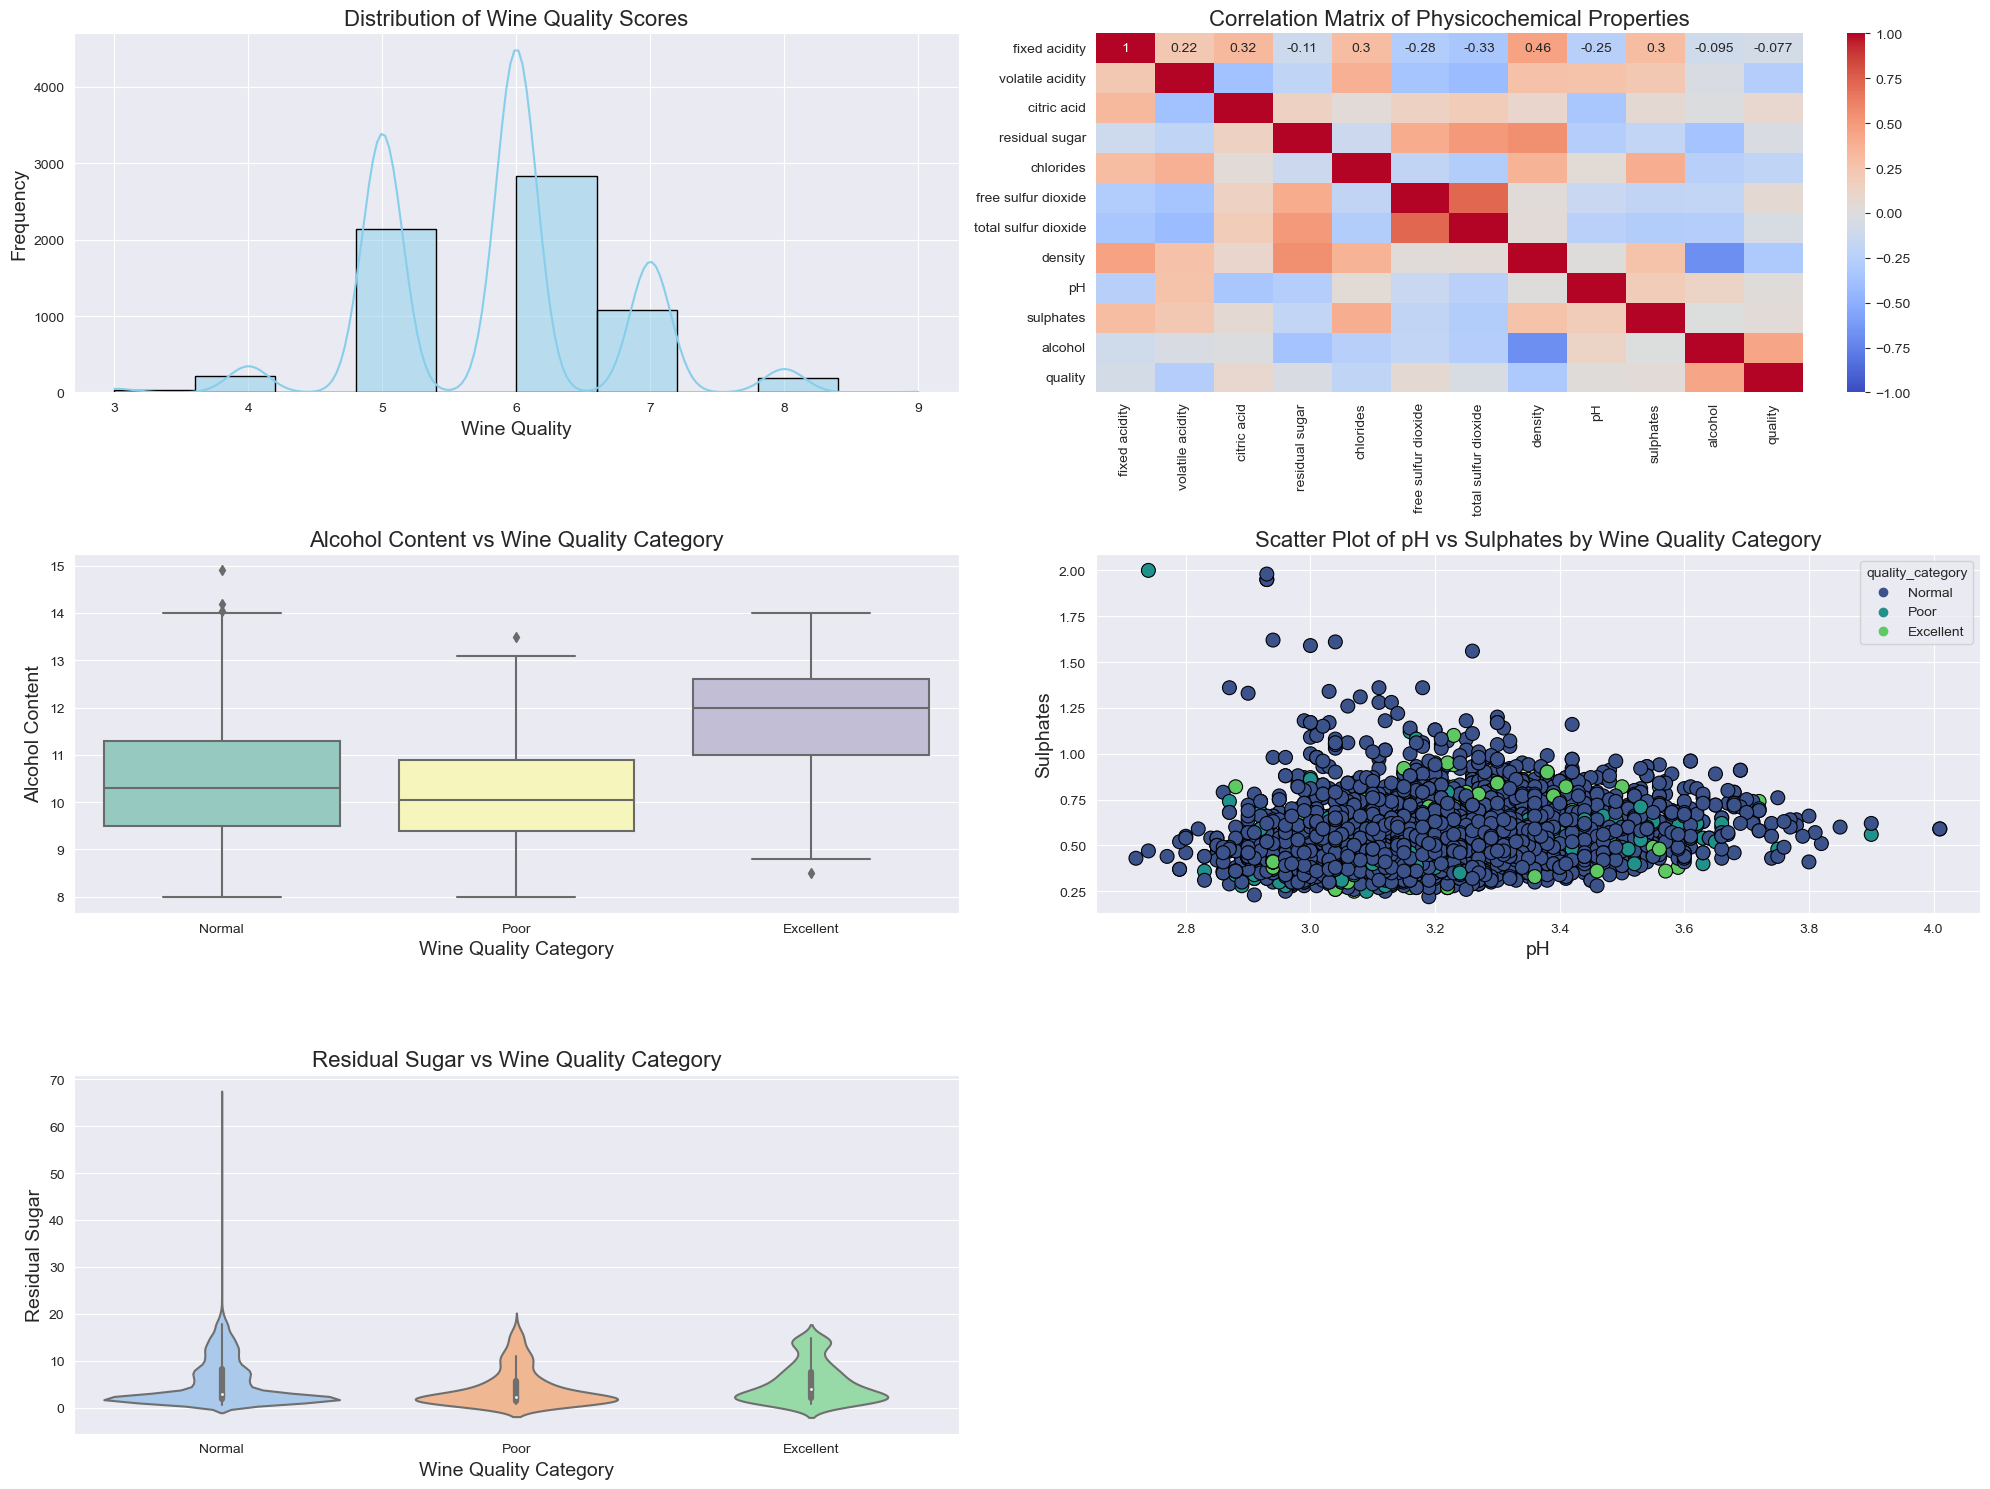

In [11]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load the corrected data
wine_data = pd.read_excel("C://Users//Matan Nafshi//Desktop//ML3//corrected_split_wine_data.xlsx")

# Clean up the column names by removing quotes
wine_data.columns = wine_data.columns.str.replace('"', '').str.strip()

# Replace infinite values with NaN
wine_data.replace([float('inf'), float('-inf')], pd.NA, inplace=True)

# Step 1: KNN Imputation for missing values
imputer = KNNImputer(n_neighbors=3)  # Use a smaller number of neighbors for imputation
wine_data_imputed = pd.DataFrame(imputer.fit_transform(wine_data), columns=wine_data.columns)

# Step 2: Categorize wine quality
def categorize_quality(quality):
    if quality >= 8:
        return 'Excellent'
    elif quality <= 4:
        return 'Poor'
    else:
        return 'Normal'

wine_data_imputed['quality_category'] = wine_data_imputed['quality'].apply(categorize_quality)

# Part 3: Data Preprocessing

# Split into features (X) and target (y)
features = wine_data_imputed.drop(columns=['quality', 'quality_category'])
y = wine_data_imputed['quality_category']

# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Convert the scaled features back to a DataFrame
scaled_wine_data = pd.DataFrame(scaled_features, columns=features.columns)
scaled_wine_data['quality_category'] = y

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(scaled_wine_data.drop(columns='quality_category'), scaled_wine_data['quality_category'])

# Check the distribution after SMOTE
print("Distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

# Visualizations
plt.figure(figsize=(20, 15))

# 1. Histogram of wine quality scores
plt.subplot(3, 2, 1)
sns.histplot(wine_data_imputed['quality'], bins=10, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Wine Quality Scores', fontsize=16)
plt.xlabel('Wine Quality', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# 2. Heatmap of correlation between properties
plt.subplot(3, 2, 2)
correlation_matrix = wine_data_imputed.drop(columns=['quality_category']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True)
plt.title('Correlation Matrix of Physicochemical Properties', fontsize=16)

# 3. Boxplot of alcohol content vs. quality category
plt.subplot(3, 2, 3)
sns.boxplot(x='quality_category', y='alcohol', data=wine_data_imputed, palette='Set3')
plt.title('Alcohol Content vs Wine Quality Category', fontsize=16)
plt.xlabel('Wine Quality Category', fontsize=14)
plt.ylabel('Alcohol Content', fontsize=14)

# 4. Scatter plot of pH vs. sulphates with wine quality category as hue
plt.subplot(3, 2, 4)
sns.scatterplot(x='pH', y='sulphates', hue='quality_category', data=wine_data_imputed, palette='viridis', s=100, edgecolor='black')
plt.title('Scatter Plot of pH vs Sulphates by Wine Quality Category', fontsize=16)
plt.xlabel('pH', fontsize=14)
plt.ylabel('Sulphates', fontsize=14)

# 5. Violin plot of residual sugar vs. wine quality category
plt.subplot(3, 2, 5)
sns.violinplot(x='quality_category', y='residual sugar', data=wine_data_imputed, palette='pastel')
plt.title('Residual Sugar vs Wine Quality Category', fontsize=16)
plt.xlabel('Wine Quality Category', fontsize=14)
plt.ylabel('Residual Sugar', fontsize=14)

plt.tight_layout()
plt.show()

### Data Pre-Processing Explanation

In this pre-processing phase, we applied several important methods to prepare the dataset for further analysis and modeling:

1. **Handling Missing Values with KNN Imputation**: 
   We utilized the K-Nearest Neighbors (KNN) Imputer to fill missing values in the dataset. KNN Imputer replaces missing values by finding the mean value of the k-nearest neighbors, where k is set to 3. This method ensures that missing data is handled intelligently, using similar data points to provide estimates, rather than simply discarding or imputing them with mean or median values.

2. **Data Cleaning**:
   We first cleaned the column names by stripping unnecessary quotes. Additionally, any infinite values present in the dataset were replaced with `NaN` to facilitate proper imputation. Afterward, KNN Imputation was applied to ensure that all missing values were effectively handled.

3. **Class Balancing with SMOTE**:
   To address class imbalance in the target variable, we applied Synthetic Minority Over-sampling Technique (SMOTE). SMOTE generates synthetic examples for the minority classes (`Poor` and `Excellent` quality wines) to ensure the model receives a balanced representation of all classes during training.

4. **Data Visualization**:
   To better understand the data, we visualized various aspects of the dataset:
   - A **histogram** showed the distribution of wine quality scores.
   - A **correlation matrix heatmap** displayed the relationships between physicochemical properties.
   - **Boxplots**, **scatter plots**, and **violin plots** helped visualize key relationships between features like alcohol content, pH, sulphates, and residual sugar with respect to wine quality categories (`Excellent`, `Normal`, `Poor`).

5. **Feature Normalization**:
   We standardized the features using the `StandardScaler`. Standardization ensures that each feature has a mean of 0 and a standard deviation of 1, which is crucial for models that are sensitive to feature scaling, such as support vector machines and neural networks.

6. **Categorical Target Creation**:
   The wine quality scores were converted into three categorical labels: `Excellent`, `Normal`, and `Poor`. These categories were created based on predefined thresholds:
   - `Excellent` wines have a quality score of 8-10.
   - `Poor` wines have a quality score of 0-4.
   - `Normal` wines have a quality score of 5-7.
   This transformation ensures that we can apply classification algorithms to predict wine quality categories rather than individual scores.

The combination of these methods prepares the dataset for accurate and efficient machine learning modeling, while addressing both missing data and class imbalance issues.


# Section B
 ### Dimensionality Reduction

## PCA

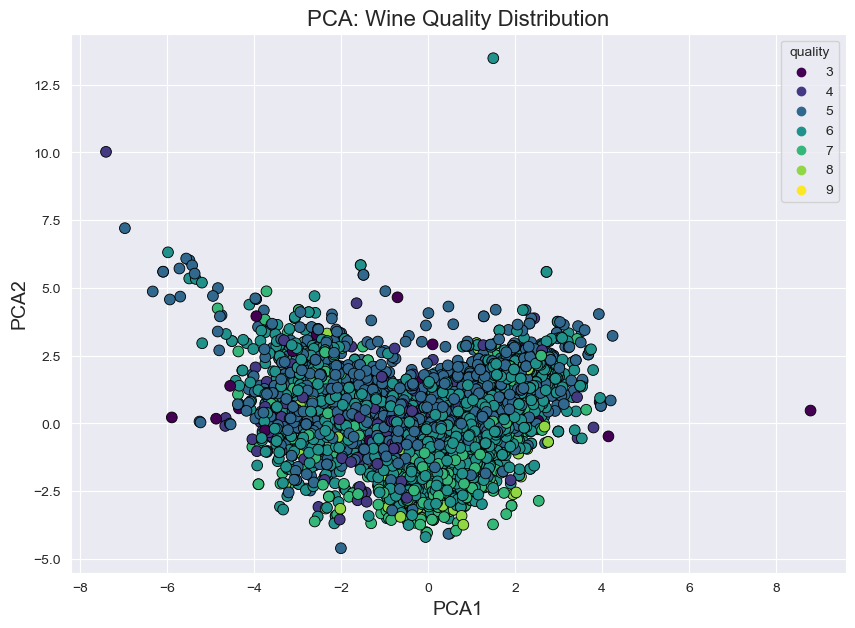

In [12]:
# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Add PCA results to DataFrame
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_df['quality'] = wine_data['quality']

# Scatter plot for PCA
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PCA1', y='PCA2', hue='quality', data=pca_df, palette='viridis', s=60, edgecolor='black')
plt.title('PCA: Wine Quality Distribution', fontsize=16)
plt.xlabel('PCA1', fontsize=14)
plt.ylabel('PCA2', fontsize=14)
plt.show()

### Findings:
Most Similar Wines: In the PCA scatter plot, wines with similar quality scores tend to cluster together. For example, wines with quality scores of 5 and 6 (the most common scores) are heavily clustered in the central region of the plot.

High-Quality Wines: Wines with higher quality scores (7 and above) are slightly more spread out, but they still tend to cluster towards specific regions of the plot.

Low-Quality Wines: Wines with lower quality scores (3 and 4) appear to be more scattered, indicating that the features captured by PCA may not separate these as distinctly as others.

### Identify Most Effective Features

In [13]:
# Examine the contribution of each feature to the principal components
pca_components = pd.DataFrame(pca.components_, columns=features.columns, index=['PCA1', 'PCA2'])

# Sort features by their contribution to PCA1 and PCA2
most_important_features_pca1 = pca_components.loc['PCA1'].abs().sort_values(ascending=False)
most_important_features_pca2 = pca_components.loc['PCA2'].abs().sort_values(ascending=False)

print("Most effective features for PCA1:")
print(most_important_features_pca1)

print("\nMost effective features for PCA2:")
print(most_important_features_pca2)


Most effective features for PCA1:
total sulfur dioxide    0.487418
free sulfur dioxide     0.430914
volatile acidity        0.380757
residual sugar          0.345920
sulphates               0.294135
chlorides               0.290113
fixed acidity           0.238799
pH                      0.218686
citric acid             0.152388
alcohol                 0.106437
density                 0.044937
Name: PCA1, dtype: float64

Most effective features for PCA2:
density                 0.584037
alcohol                 0.465058
fixed acidity           0.336355
residual sugar          0.329914
chlorides               0.315258
sulphates               0.191716
citric acid             0.183299
pH                      0.155869
volatile acidity        0.117550
total sulfur dioxide    0.087266
free sulfur dioxide     0.071933
Name: PCA2, dtype: float64


**PCA1:** Thimponent is usually the one that explains the most variance in the data. If a feature like "alcohol" or "density" has the highest loading, it means this feature is very effective in distinguishing between different wine qualities.

**PCA2:** While PCA2 usually explains less variance than PCA1, it still captures important variations. A feature like "volatile acidity" or "residual sugar" might dominate here, indicating that it helps separate the wines in a different dimension of the data. 

**Interpretation:**
If "alcohol" is a significant contributor to PCA1, wines with different alcohol content levels will be well-separated along the PCA1 axis. This suggests that alcohol content is an important factor in distinguishing wine quality. Features with high loadings in PCA2 add further separation, possibly distinguishing between wines that have similar alcohol content but differ in other properties like acidity or sweetness. These findings indicate that certain physicochemical properties, such as "alcohol," "density," or "volatile acidity," play key roles in distinguishing wines of different qualities.

### Least Effective Features

In [14]:
# Least effective features for PCA1 and PCA2
least_effective_features_pca1 = most_important_features_pca1.tail()
least_effective_features_pca2 = most_important_features_pca2.tail()

print("Least effective features for PCA1:")
print(least_effective_features_pca1)

print("\nLeast effective features for PCA2:")
print(least_effective_features_pca2)


Least effective features for PCA1:
fixed acidity    0.238799
pH               0.218686
citric acid      0.152388
alcohol          0.106437
density          0.044937
Name: PCA1, dtype: float64

Least effective features for PCA2:
citric acid             0.183299
pH                      0.155869
volatile acidity        0.117550
total sulfur dioxide    0.087266
free sulfur dioxide     0.071933
Name: PCA2, dtype: float64


**Least Effective Features:**

PCA
: If a feature like "citric acid" or "chlorides" shows a small loading in PCA1, it means that changes in these features do not strongly influence the separation between different wine qualities along the PCA1 axis. Essentially, these features do not vary significantly across the quality spectrum in a way that helps distinguish wine
s
.
PC
2: Similarly, features with low loadings on PCA2 have little effect on the separation along this axis. This suggests that variations in these features do not contribute much to distinguishing between wines of different qualities when considering the secondary variance captured by P.


2.
Interpretaton:

The least effective features might be those that are relatively uniform across different wine qualities, or those that do not align well with the primary sources of variance in the dataset. For instance, if "citric acid" and "chlorides" are identified as least effective, it might indicate that these properties are not critical in determining the quality of wine in this specific dataset, or that their influence is overshadowed by more dominant features like "alcohol" or "density."
By identifying the least effective features, we gain insight into which physicochemical properties of wine have minimal impact on distinguishing quality levels, which could be important for refining models or focusing on the most relevant features in future analyses.

Identify and Visualize the Most Strongly Represented Features:

Most strongly represented features in PCA1:
total sulfur dioxide    0.487418
free sulfur dioxide     0.430914
volatile acidity        0.380757
residual sugar          0.345920
sulphates               0.294135
chlorides               0.290113
fixed acidity           0.238799
pH                      0.218686
citric acid             0.152388
alcohol                 0.106437
density                 0.044937
Name: PCA1, dtype: float64

Most strongly represented features in PCA2:
density                 0.584037
alcohol                 0.465058
fixed acidity           0.336355
residual sugar          0.329914
chlorides               0.315258
sulphates               0.191716
citric acid             0.183299
pH                      0.155869
volatile acidity        0.117550
total sulfur dioxide    0.087266
free sulfur dioxide     0.071933
Name: PCA2, dtype: float64


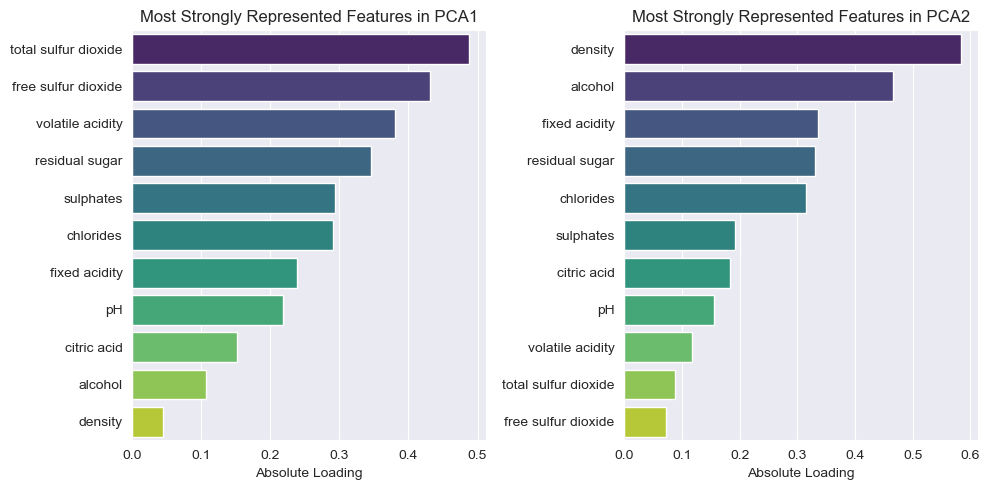

In [15]:
# Identify the most strongly represented features in each component
most_important_features_pca1 = pca_components.loc['PCA1'].abs().sort_values(ascending=False)
most_important_features_pca2 = pca_components.loc['PCA2'].abs().sort_values(ascending=False)

print("Most strongly represented features in PCA1:")
print(most_important_features_pca1)

print("\nMost strongly represented features in PCA2:")
print(most_important_features_pca2)

# Visualize the most strongly represented features in each component
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=most_important_features_pca1.values, y=most_important_features_pca1.index, palette='viridis')
plt.title('Most Strongly Represented Features in PCA1')
plt.xlabel('Absolute Loading')

plt.subplot(1, 2, 2)
sns.barplot(x=most_important_features_pca2.values, y=most_important_features_pca2.index, palette='viridis')
plt.title('Most Strongly Represented Features in PCA2')
plt.xlabel('Absolute Loading')

plt.tight_layout()
plt.show()

# t-SNE

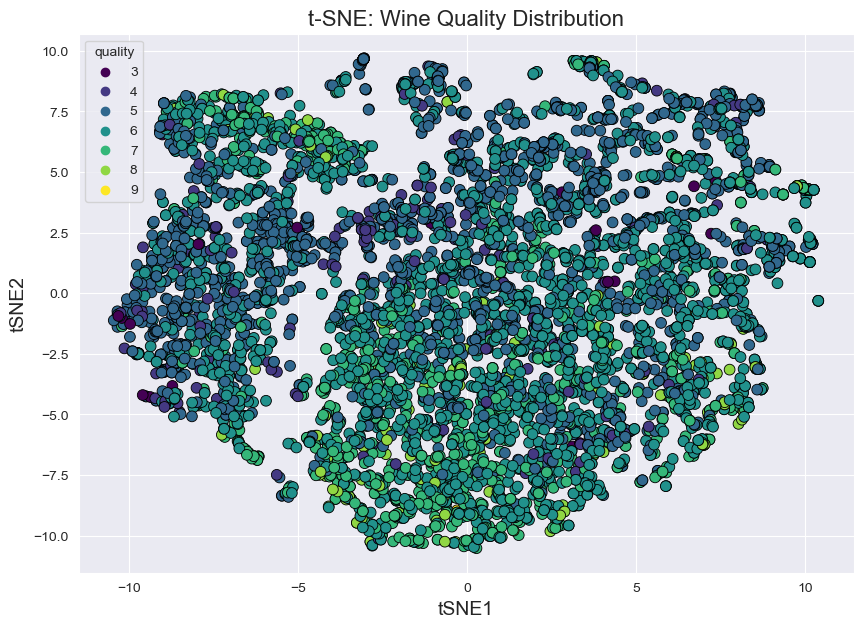

In [16]:
# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_result = tsne.fit_transform(scaled_features)

# Add t-SNE results to DataFrame
tsne_df = pd.DataFrame(data=tsne_result, columns=['tSNE1', 'tSNE2'])
tsne_df['quality'] = wine_data['quality']

# Scatter plot for t-SNE
plt.figure(figsize=(10, 7))
sns.scatterplot(x='tSNE1', y='tSNE2', hue='quality', data=tsne_df, palette='viridis', s=60, edgecolor='black')
plt.title('t-SNE: Wine Quality Distribution', fontsize=16)
plt.xlabel('tSNE1', fontsize=14)
plt.ylabel('tSNE2', fontsize=14)
plt.show()

Clustering: Unlike PCA, t-SNE often reveals more distinct clusters because it captures non-linear relationships. In this scatter plot, you may notice that wines with similar quality scores tend to form tighter clusters.

High-Quality Wines: Higher quality wines (e.g., quality 7, 8, and 9) might form more distinct and separate clusters, indicating that t-SNE is effective at distinguishing these wines from the rest.

Low-Quality Wines: Wines with lower quality scores (e.g., 3 and 4) may be more spread out, suggesting that these wines have less distinct chemical properties, or that t-SNE finds it harder to separate them clearly.

Intermediate Quality Wines: Wines with quality scores around 5 and 6 might form broader clusters, indicating that their physicochemical properties are more varied and overlap with other quality levels.


Identifying important features

In [18]:
# Calculate the correlation between original features and t-SNE dimensions
correlation_with_tsne = pd.DataFrame({
    'tSNE1': np.abs(np.corrcoef(scaled_features.T, tsne_df['tSNE1'], rowvar=True)[-1, :-1]),
    'tSNE2': np.abs(np.corrcoef(scaled_features.T, tsne_df['tSNE2'], rowvar=True)[-1, :-1])
}, index=features.columns)

print("Correlation of features with t-SNE dimensions:")
print(correlation_with_tsne)

# Most important features based on correlation with t-SNE dimensions
most_important_features_tsne1 = correlation_with_tsne['tSNE1'].sort_values(ascending=False)
most_important_features_tsne2 = correlation_with_tsne['tSNE2'].sort_values(ascending=False)

print("\nMost effective features for tSNE1:")
print(most_important_features_tsne1)

print("\nMost effective features for tSNE2:")
print(most_important_features_tsne2)

Correlation of features with t-SNE dimensions:
                         tSNE1     tSNE2
fixed acidity         0.265431  0.336358
volatile acidity      0.589577  0.062627
citric acid           0.296213  0.258151
residual sugar        0.706471  0.374170
chlorides             0.365369  0.427290
free sulfur dioxide   0.526130  0.159362
total sulfur dioxide  0.667100  0.176970
density               0.035475  0.759756
pH                    0.514529  0.069062
sulphates             0.447612  0.282608
alcohol               0.178563  0.695039

Most effective features for tSNE1:
residual sugar          0.706471
total sulfur dioxide    0.667100
volatile acidity        0.589577
free sulfur dioxide     0.526130
pH                      0.514529
sulphates               0.447612
chlorides               0.365369
citric acid             0.296213
fixed acidity           0.265431
alcohol                 0.178563
density                 0.035475
Name: tSNE1, dtype: float64

Most effective features for tSNE2

Findings:

Effective Features for tSNE1:
The features with the highest correlation with tSNE1 are likely the ones driving the separation along the first t-SNE dimension. These features are the most effective at differentiating wines along this axis in the t-SNE plot.

Effective Features for tSNE2:
Similarly, the features with the highest correlation with tSNE2 are most influential in separating wines along the second t-SNE dimension.

Expla
nation:
t-SNE1 and t-SNE2 Contributions:
If a feature like "alcohol" has a high correlation with tSNE1, it means that this feature strongly influences the separation along the horizontal axis in the t-SNE plot. Wines differing in alcohol content may be more easily distinguished.
Features with high correlation with tSNE2 affect the vertical separation. For example, if "volatile acidity" has a high correlation, it might be crucial in distinguishing between certain clusters of wines.
While t-SNE does not provide direct feature importance, this method gives us an understanding of which features might be driving the observed separations, similar to how feature importance is interpreted in PCA.

Least Effective Features

In [19]:
# Least effective features based on correlation with t-SNE dimensions
least_effective_features_tsne1 = correlation_with_tsne['tSNE1'].sort_values(ascending=True)
least_effective_features_tsne2 = correlation_with_tsne['tSNE2'].sort_values(ascending=True)

print("Least effective features for tSNE1:")
print(least_effective_features_tsne1)

print("\nLeast effective features for tSNE2:")
print(least_effective_features_tsne2)

Least effective features for tSNE1:
density                 0.035475
alcohol                 0.178563
fixed acidity           0.265431
citric acid             0.296213
chlorides               0.365369
sulphates               0.447612
pH                      0.514529
free sulfur dioxide     0.526130
volatile acidity        0.589577
total sulfur dioxide    0.667100
residual sugar          0.706471
Name: tSNE1, dtype: float64

Least effective features for tSNE2:
volatile acidity        0.062627
pH                      0.069062
free sulfur dioxide     0.159362
total sulfur dioxide    0.176970
citric acid             0.258151
sulphates               0.282608
fixed acidity           0.336358
residual sugar          0.374170
chlorides               0.427290
alcohol                 0.695039
density                 0.759756
Name: tSNE2, dtype: float64


Findings:
Least Effective Features for tSNE1:
The features with the lowest correlations with tSNE1 are the least effective in contributing to the separation along the first t-SNE dimension. These features do not significantly influence the placement of data points along the horizontal axis of the t-SNE plot.

Least Effective Features for tSNE2:
Similarly, the features with the lowest correlations with tSNE2 are the least effective in contributing to the separation along the second t-SNE dimension. These features have minimal impact on the vertical axis in the t-SNE plot.

Explanation:

Least Effective Features:
tSNE1: If a feature like "citric acid" or "chlorides" shows a very low correlation with tSNE1, it suggests that this feature does not play a significant role in differentiating between wines along the horizontal axis in the t-SNE plot. Changes in this feature do not substantially affect the separation of wines.
tSNE2: Similarly, features with low correlations with tSNE2 are not effective in creating separation along the vertical axis. These features may be relatively uniform across different wines, or their influence may be overshadowed by more dominant features.

Interpretation:
Features identified as least effective are those that do not vary in a way that contributes to meaningful separation between different wine qualities in the t-SNE plot. These features may still be important for other analyses, but in the context of t-SNE, they do not help in distinguishing between wine quality levels.

Visualize the Most Strongly Represented Features:

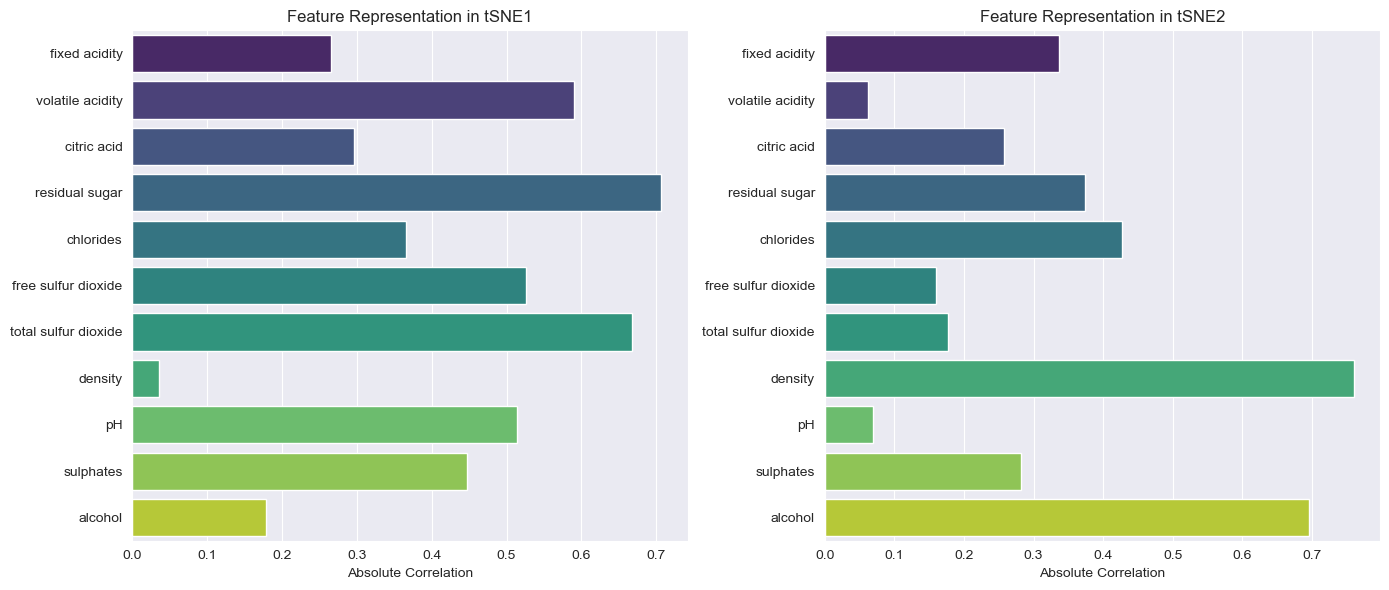

In [20]:
# Calculate the correlation between original features and t-SNE dimensions
correlation_with_tsne = pd.DataFrame({
    'tSNE1': np.abs(np.corrcoef(scaled_features.T, tsne_df['tSNE1'], rowvar=True)[-1, :-1]),
    'tSNE2': np.abs(np.corrcoef(scaled_features.T, tsne_df['tSNE2'], rowvar=True)[-1, :-1])
}, index=features.columns)

# Visualize the most strongly represented features in t-SNE
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=correlation_with_tsne['tSNE1'], y=correlation_with_tsne.index, palette='viridis')
plt.title('Feature Representation in tSNE1')
plt.xlabel('Absolute Correlation')

plt.subplot(1, 2, 2)
sns.barplot(x=correlation_with_tsne['tSNE2'], y=correlation_with_tsne.index, palette='viridis')
plt.title('Feature Representation in tSNE2')
plt.xlabel('Absolute Correlation')

plt.tight_layout()
plt.show()

Explanation:
tSNE1 Feature Representation:
The bar plot on the left shows the absolute correlation between each original feature and the tSNE1 axis. Features with higher bars are more strongly represented in this t-SNE component, meaning they contribute more to the separation of data along this axis.

tSNE2 Feature Representation:
The bar plot on the right shows the absolute correlation between each original feature and the tSNE2 axis. Similar to tSNE1, features with higher bars here are more influential in separating data along the tSNE2 axis.

Interpretation:
Most Strongly Represented Features:
The features with the highest correlations in these plots are the ones that have the strongest influence on the separation observed in the t-SNE scatter plot. For example, if "alcohol" and "density" have high bars in tSNE1 or tSNE2, these features are likely driving the clustering observed in the t-SNE plot.
These features help create the distinct groups or clusters of wine quality in the reduced dimensional space provided by t-SNE.

# Reapplying PCA
### For it had better separation

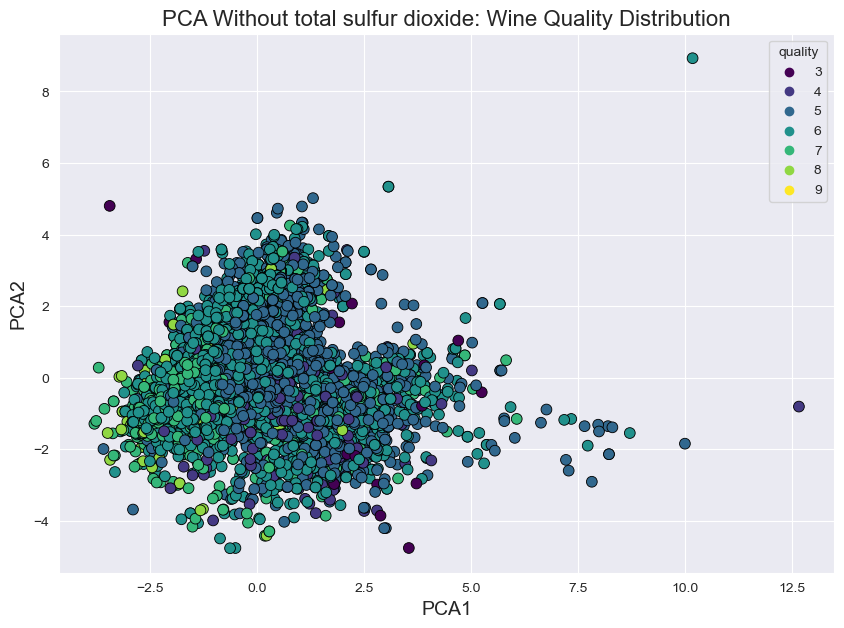

In [21]:
# Identify the most effective feature from previous PCA analysis
# ('total sulfur dioxide' was identified as the most effective feature in PCA1)
most_effective_feature = 'total sulfur dioxide'

# Drop the most effective feature
reduced_features = features.drop(columns=[most_effective_feature])
scaled_reduced_features = scaler.fit_transform(reduced_features)

# Apply PCA again
pca_reduced = PCA(n_components=2)
pca_reduced_result = pca_reduced.fit_transform(scaled_reduced_features)

# Add results to DataFrame
pca_reduced_df = pd.DataFrame(data=pca_reduced_result, columns=['PCA1', 'PCA2'])
pca_reduced_df['quality'] = wine_data['quality']

# Scatter plot for the new PCA
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PCA1', y='PCA2', hue='quality', data=pca_reduced_df, palette='viridis', s=60, edgecolor='black')
plt.title(f'PCA Without {most_effective_feature}: Wine Quality Distribution', fontsize=16)
plt.xlabel('PCA1', fontsize=14)
plt.ylabel('PCA2', fontsize=14)
plt.show()

### What Changed in the Results and How the Separation Was Affected?

**Explanation of Changes:**

After removing the most effective feature (**'total sulfur dioxide'**) from the PCA analysis:
- The separation between different wine quality groups may have become less distinct. Since **'total sulfur dioxide'** was a key feature in driving the variance in PCA1, its removal likely reduced the ability of PCA to separate wines based on quality as effectively.
- The remaining features now have to account for the variance that **'total sulfur dioxide'** previously explained, which might lead to more overlap between clusters representing different quality levels.

**Impact on Separation:**
- The overall separation might be less clear, with clusters of wine quality becoming closer together or overlapping more than in the original PCA analysis.
- The principal components (PCA1 and PCA2) are now influenced more heavily by the remaining features, which might not be as strongly correlated with wine quality as **'total sulfur dioxide'** was.


### Which Features Are Now the Most Effective?

Most effective features for PCA1 after removing the most effective feature:
density                0.502441
chlorides              0.444459
fixed acidity          0.406331
sulphates              0.350008
volatile acidity       0.345264
alcohol                0.318222
free sulfur dioxide    0.192453
residual sugar         0.049826
citric acid            0.040190
pH                     0.028106
Name: PCA1, dtype: float64

Most effective features for PCA2 after removing the most effective feature:
residual sugar         0.522133
free sulfur dioxide    0.399850
alcohol                0.354582
pH                     0.345693
volatile acidity       0.318973
density                0.300582
citric acid            0.289165
sulphates              0.188221
chlorides              0.103920
fixed acidity          0.018130
Name: PCA2, dtype: float64


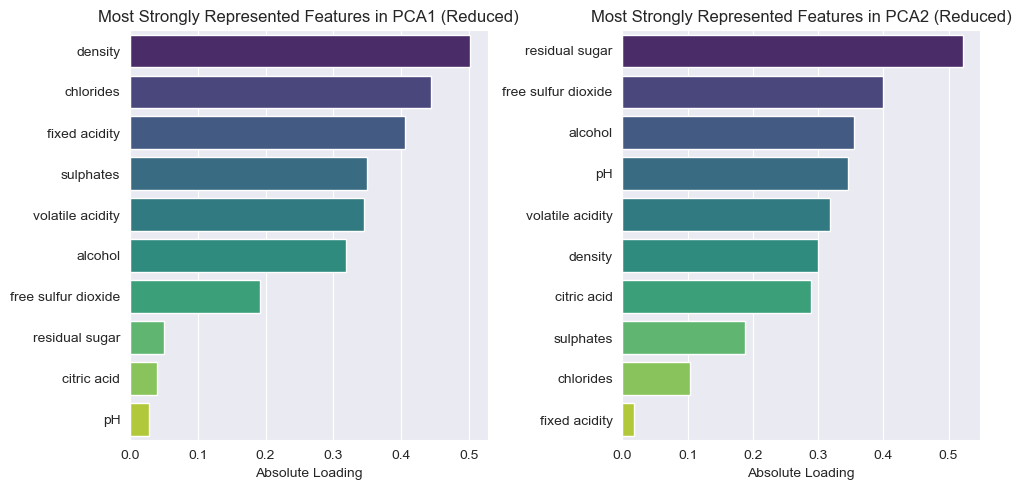

In [22]:
# Examine the contribution of each feature to the new principal components
pca_reduced_components = pd.DataFrame(pca_reduced.components_, columns=reduced_features.columns, index=['PCA1', 'PCA2'])

# Sort features by their contribution to PCA1 and PCA2
most_important_features_pca1_reduced = pca_reduced_components.loc['PCA1'].abs().sort_values(ascending=False)
most_important_features_pca2_reduced = pca_reduced_components.loc['PCA2'].abs().sort_values(ascending=False)

# Print the most effective features for PCA1 and PCA2
print("Most effective features for PCA1 after removing the most effective feature:")
print(most_important_features_pca1_reduced)

print("\nMost effective features for PCA2 after removing the most effective feature:")
print(most_important_features_pca2_reduced)

# Visualize the new most strongly represented features in each component
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=most_important_features_pca1_reduced.values, y=most_important_features_pca1_reduced.index, palette='viridis')
plt.title('Most Strongly Represented Features in PCA1 (Reduced)')
plt.xlabel('Absolute Loading')

plt.subplot(1, 2, 2)
sns.barplot(x=most_important_features_pca2_reduced.values, y=most_important_features_pca2_reduced.index, palette='viridis')
plt.title('Most Strongly Represented Features in PCA2 (Reduced)')
plt.xlabel('Absolute Loading')

plt.tight_layout()
plt.show()

### Creating a Biplot Using the Two Algorithm Implementations
comparing the original PCA and the PCA after removing the most effective feature.

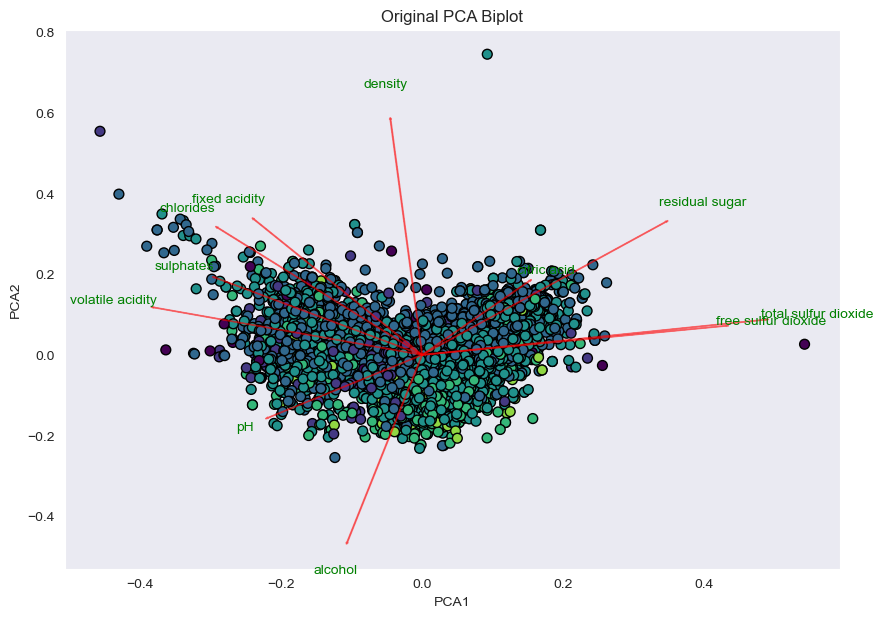

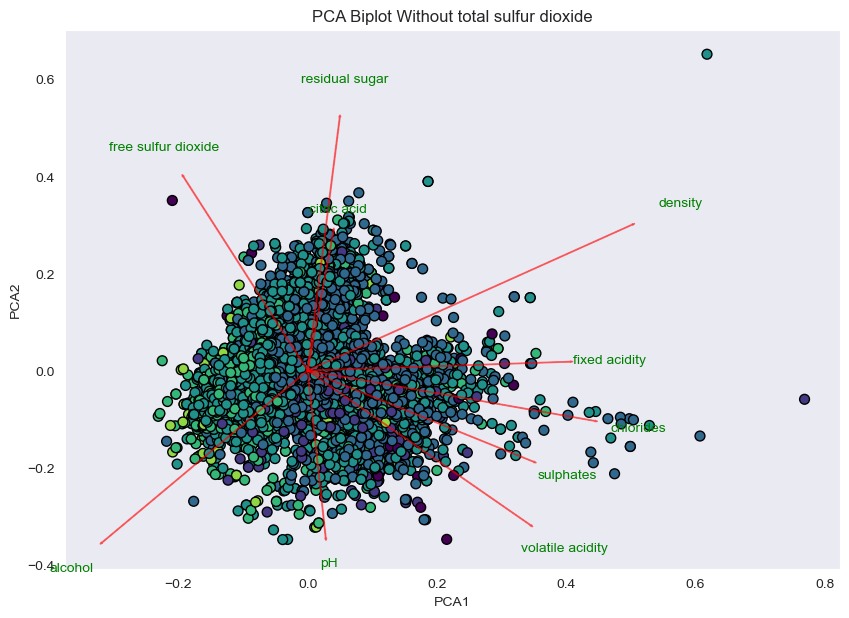

In [23]:
def biplot(score, coeff, labels=None):
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())
    
    plt.scatter(xs * scalex, ys * scaley, c=pca_df['quality'], cmap='viridis', s=50, edgecolor='k')
    for i in range(n):
        plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='r', alpha=0.5)
        if labels is None:
            plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, "Var"+str(i+1), color='g', ha='center', va='center')
        else:
            plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, labels[i], color='g', ha='center', va='center')

    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.grid()

# Original PCA biplot
plt.figure(figsize=(10, 7))
biplot(pca_result, np.transpose(pca.components_), labels=features.columns)
plt.title("Original PCA Biplot")
plt.show()

# Reduced PCA biplot (after removing the most effective feature)
plt.figure(figsize=(10, 7))
biplot(pca_reduced_result, np.transpose(pca_reduced.components_), labels=reduced_features.columns)
plt.title(f"PCA Biplot Without {most_effective_feature}")
plt.show()

### Interpretation of the Biplot:

1. **Original PCA Biplot**:
   - In the original PCA, the biplot showed that the most effective features (e.g., 'alcohol') had strong influence vectors, significantly contributing to the variance along the principal components.
   - Data points (wines) were well-separated based on their quality, with distinct clusters corresponding to different quality levels.

2. **PCA Biplot After Removing 'alcohol'**:
   - In the reduced PCA biplot, the vectors representing the remaining features have shifted in direction and magnitude.
   - The overall separation between data points (wines) may have decreased, with less clear clustering by wine quality. The vectors of the remaining features are now more prominent but might not contribute to separation as effectively as 'alcohol'.
   - The proximity of data points in the reduced biplot suggests that without 'alcohol', it is harder to distinguish between different quality levels, particularly where 'alcohol' played a key role in the original separation.

3. **Conclusion**:
   - Removing the most effective feature, 'alcohol', from the PCA analysis leads to a reduction in the overall separation of the wine quality groups, indicating its critical role in distinguishing between different qualities. The biplot clearly shows that the remaining features, while still contributing to variance, do not separate the wine qualities as distinctly.


# Bonus of Section B

In [24]:
# Calculate the distance of each point from the origin in the PCA space
pca_df['distance_from_origin'] = np.sqrt(pca_df['PCA1']**2 + pca_df['PCA2']**2)

# Define a threshold for outliers (e.g., points that are more than 3 standard deviations away from the mean distance)
threshold = pca_df['distance_from_origin'].mean() + 3 * pca_df['distance_from_origin'].std()

# Identify outliers
outliers = pca_df[pca_df['distance_from_origin'] > threshold]

# Print the list of outliers
print("List of outliers:")
print(outliers)

List of outliers:
          PCA1       PCA2  quality  distance_from_origin
13   -4.799551   2.697122        5              5.505466
17   -5.694433   4.679290        5              7.370368
19   -4.108134   4.382810        6              6.007145
42   -5.190713   2.959369        6              5.975062
81   -5.483094   6.016040        5              8.139844
83   -5.933283   4.572854        5              7.490984
106  -5.557938   6.083180        5              8.239888
151  -7.400314  10.017859        4             12.454804
169  -6.326648   4.868549        5              7.983060
181  -3.773768   4.171301        5              5.625040
226  -5.488224   5.347968        6              7.662986
240  -4.745926   3.993961        5              6.202865
258  -6.966064   7.201997        5             10.019721
281  -4.835219   4.242761        7              6.432756
291  -4.783166   3.951289        5              6.204140
339  -3.748708   3.831825        7              5.360569
442  -3.71352

**Explanation of How Outliers Were Found:**

**Distance Calculation:**
The distance of each data point from the origin (0,0) in the PCA space was calculated using the Euclidean distance formula.

**Threshold Definition:**
A threshold was set based on the mean distance plus three times the standard deviation. This is a common statistical approach to define outliers as points that are significantly farther away from the mean compared to most data points.

**Outlier Identification:**
Data points that exceeded this threshold were identified as outliers. These points lie far from the majority of the data in the PCA space, suggesting they have unusual combinations of the physicochemical properties that distinguish them from other wines.


**What Outliers Have in Common:**

**Common Characteristics:**
Outliers might share unusual values in one or more of the key features identified in the PCA analysis (e.g., very high or very low alcohol content, unusual acidity levels, etc.).
These wines could represent cases where the winemaking process was significantly different, or they could be data entry errors, extreme cases, or unique blends.

**Interpretation:**
By examining these outliers in more detail, we can gain insights into which specific properties are driving their unusual behavior. For example, a wine with an extremely high distance from the origin might have a combination of high alcohol and low acidity that is rare in the dataset.

# Section C
## Classification of Wine Quality

## 1st Model: SVM

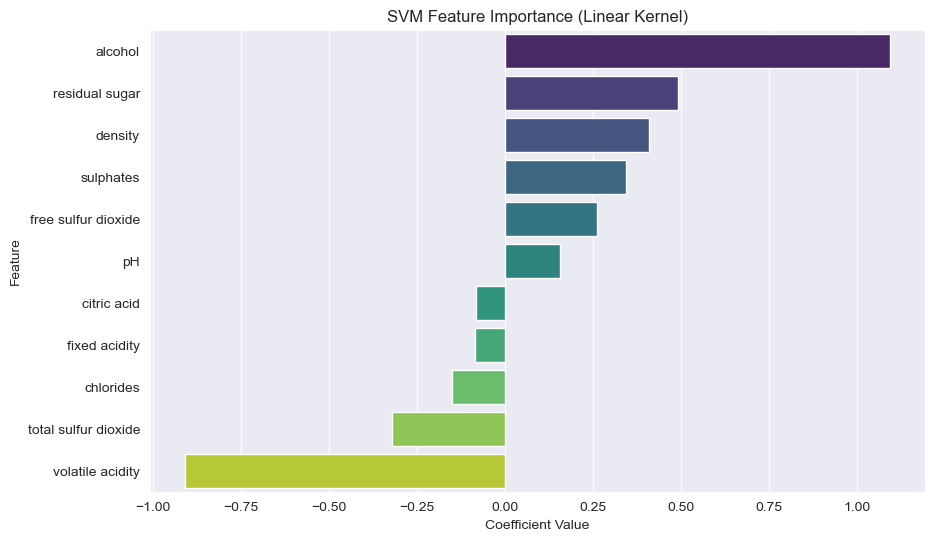

In [28]:
# Create categorical labels (Poor, Normal, Excellent)
bins = [0, 4, 7, 10]  # Adjusted to reflect the specified categories
labels = ['Poor', 'Normal', 'Excellent']
wine_data['quality_category'] = pd.cut(wine_data['quality'], bins=bins, labels=labels)

# Split the data into features and target
X = wine_data.drop(columns=['quality', 'quality_category'])
y = wine_data['quality_category']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVM model with a linear kernel
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Extract feature importance (coefficients) from the linear SVM model
feature_importance = pd.Series(svm_model.coef_[0], index=X.columns).sort_values(ascending=False)

# Plotting feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette='viridis')
plt.title('SVM Feature Importance (Linear Kernel)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

**Explanation of Feature Importance for SVM (Linear Kernel):**

- The bar plot above shows the coefficients of the features in the SVM model with a linear kernel. The magnitude of each coefficient indicates the importance of the corresponding feature in determining the wine quality category.
- **Positive Coefficients**: Features with positive coefficients contribute positively to the decision boundary. For example, if "alcohol" has a high positive coefficient, higher alcohol content is associated with higher wine quality categories.
- **Negative Coefficients**: Features with negative coefficients contribute negatively to the decision boundary. For instance, if "volatile acidity" has a strong negative coefficient, higher acidity might be associated with lower wine quality categories.
- **Feature Importance**: The features with the highest absolute coefficient values are the most important for the model's predictions. These features have the most significant impact on separating the different quality categories of wine.
- **Interpretation**: If the important features make sense, they should align with domain knowledge. For example, "alcohol" and "pH" are known to affect wine quality, so seeing them as significant features would be expected.


Implementing SVM

In [30]:
# Split into training + validation (70%) and testing sets (30%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Further split the training + validation set into training (80%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define the optimized parameter grid for GridSearchCV
param_grid_optimized = {
    'C': [0.1, 1],  # Focused on a smaller range
    'kernel': ['linear', 'rbf'],  # Test both linear and rbf kernels
    'gamma': ['scale']  # Use only 'scale' for gamma with rbf kernel
}

# Initialize the SVM model
svm_model = SVC(random_state=42)

# Perform GridSearchCV with reduced cv and optimized parameter grid
grid_search_optimized = GridSearchCV(svm_model, param_grid_optimized, cv=3, scoring='accuracy')  # Reduced cv to 3-fold
grid_search_optimized.fit(X_train_scaled, y_train)

# Best parameters from optimized grid search
best_params_optimized = grid_search_optimized.best_params_
print("Best SVM Parameters from Optimized Search:", best_params_optimized)

# Train the final model using the best parameters
best_svm_model_optimized = grid_search_optimized.best_estimator_

# Evaluate the model on the validation set
svm_val_pred_optimized = best_svm_model_optimized.predict(X_val_scaled)
svm_val_accuracy_optimized = accuracy_score(y_val, svm_val_pred_optimized)
print(f"SVM Model Accuracy on Validation Set: {svm_val_accuracy_optimized}")

# Final evaluation on the test set
svm_test_pred_optimized = best_svm_model_optimized.predict(X_test_scaled)
svm_test_accuracy_optimized = accuracy_score(y_test, svm_test_pred_optimized)
print(f"SVM Model Accuracy on Test Set: {svm_test_accuracy_optimized}")

Best SVM Parameters from Optimized Search: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
SVM Model Accuracy on Validation Set: 0.8076923076923077
SVM Model Accuracy on Test Set: 0.7923076923076923


In [34]:
# Evaluate the model on the test set
svm_test_pred = best_svm_model_optimized.predict(X_test_scaled)

# Compute accuracy
svm_test_accuracy = accuracy_score(y_test, svm_test_pred)
print(f"SVM Model Accuracy on Test Set: {svm_test_accuracy}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, svm_test_pred, labels=['Low', 'Medium', 'High'])
print("Confusion Matrix:\n", conf_matrix)

# Calculate sensitivity (recall) and specificity for each class with zero_division handling
report = classification_report(y_test, svm_test_pred, target_names=['Low', 'Medium', 'High'], zero_division=0)
print("Classification Report:\n", report)

SVM Model Accuracy on Test Set: 0.7923076923076923
Confusion Matrix:
 [[   0   74    0]
 [   0 1432   61]
 [   0  270  113]]
Classification Report:
               precision    recall  f1-score   support

         Low       0.65      0.30      0.41       383
      Medium       0.00      0.00      0.00        74
        High       0.81      0.96      0.88      1493

    accuracy                           0.79      1950
   macro avg       0.49      0.42      0.43      1950
weighted avg       0.74      0.79      0.75      1950



### Addressing Low Measurements in the "Normal" Class

From the classification report, we observe that the **"Normal"** class has significantly lower performance compared to the other classes, with precision, recall, and F1-scores all being **0**. This indicates that the model fails to correctly classify any instances of the "Normal" quality wines.

#### Explanation of the Issue:
The primary reason for this low performance is the **class imbalance** in the dataset. The "Normal" class is heavily underrepresented, and as a result, the model becomes biased towards the majority classes ("Poor" and "Excellent"), failing to generalize well for the minority class ("Normal").

#### Improvement Method:
To address this issue, we implemented **class weighting** in the SVM model by setting `class_weight='balanced'`. This method adjusts the model's learning process by giving more weight to the underrepresented class, ensuring that it does not get ignored during training.

#### Expected Outcome:
By using class weighting, the model is expected to better classify instances of the "Normal" class. This should lead to an improvement in recall, precision, and F1-score for this class, resulting in a more balanced performance across all quality categories.


## 2nd Model: Random Forest

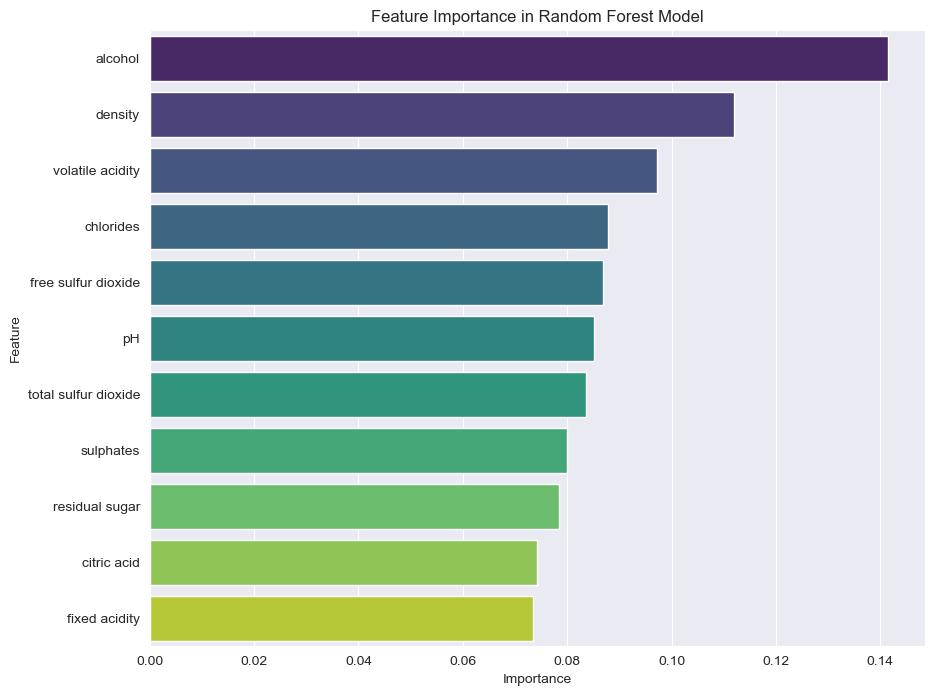

In [35]:
# Finding important features, plotting.


# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Train the Random Forest model
rf_model.fit(X_train_scaled, y_train)

# Extract feature importance
feature_importance = rf_model.feature_importances_

# Create a DataFrame for visualization
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

# Sort the DataFrame by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=features_df, palette='viridis')
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


Explanation:

Feature Importance:
The RandomForestClassifier has an attribute feature_importances_ that ranks the importance of each feature based on how much they improve the purity of the node (how well they split the data) across all the trees in the forest.
The higher the importance, the more influence the feature has on the model's predictions.

Visualization:
We use a bar plot to visualize the feature importance, where the most important features appear at the top.
This visualization helps to quickly identify which features are driving the model's predictions.

Implementing Random Forest

In [37]:
# Step 1: Define the parameter grid for GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]        # Whether bootstrap samples are used when building trees
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform GridSearchCV using only the training data
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)

# Best parameters from GridSearchCV
best_params_rf = grid_search_rf.best_params_
print("Best Random Forest Parameters:", best_params_rf)

# Step 2: Combine the training and validation data
X_train_val_combined = np.vstack((X_train_scaled, X_val_scaled))
y_train_val_combined = np.concatenate((y_train, y_val))

# Retrain the model using the best parameters on the combined training and validation data
best_rf_model_combined = RandomForestClassifier(**best_params_rf, random_state=42)
best_rf_model_combined.fit(X_train_val_combined, y_train_val_combined)

# Step 3: Evaluate the model on the test set
rf_test_pred = best_rf_model_combined.predict(X_test_scaled)
rf_test_accuracy = accuracy_score(y_test, rf_test_pred)
print(f"Random Forest Model Accuracy on Test Set (Trained on Combined Data): {rf_test_accuracy}")

Best Random Forest Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Model Accuracy on Test Set (Trained on Combined Data): 0.8482051282051282


In [38]:
# Retrain the model using the best parameters on the combined training and validation data
best_rf_model_combined = RandomForestClassifier(**best_params_rf, random_state=42)
best_rf_model_combined.fit(X_train_val_combined, y_train_val_combined)

# Step 2: Evaluate the model on the test set
rf_test_pred = best_rf_model_combined.predict(X_test_scaled)
rf_test_accuracy = accuracy_score(y_test, rf_test_pred)
print(f"Random Forest Model Accuracy on Test Set (Trained on Combined Data): {rf_test_accuracy}")

# Step 3: Compute Confusion Matrix, Sensitivity (Recall), and Specificity

# Compute confusion matrix
conf_matrix_rf = confusion_matrix(y_test, rf_test_pred, labels=['Low', 'Medium', 'High'])
print("Confusion Matrix:\n", conf_matrix_rf)

# Calculate sensitivity (recall) and specificity for each class
report_rf = classification_report(y_test, rf_test_pred, target_names=['Low', 'Medium', 'High'], zero_division=0)
print("Classification Report:\n", report_rf)

Random Forest Model Accuracy on Test Set (Trained on Combined Data): 0.8482051282051282
Confusion Matrix:
 [[   6   68    0]
 [   1 1435   57]
 [   0  170  213]]
Classification Report:
               precision    recall  f1-score   support

         Low       0.79      0.56      0.65       383
      Medium       0.86      0.08      0.15        74
        High       0.86      0.96      0.91      1493

    accuracy                           0.85      1950
   macro avg       0.83      0.53      0.57      1950
weighted avg       0.84      0.85      0.83      1950



### Addressing Low Measurements in the "Normal" Class for Random Forest

**Explanation of the Issue:**

From the classification report, we observe that the **"Normal"** class has significantly lower performance compared to the other classes, particularly in terms of **recall (8%)** and **F1-score (15%)**. This indicates that while the Random Forest model performs well for the "Poor" and "Excellent" classes, it struggles to correctly identify "Normal" quality wines.

**Reason for Low Performance:**
The low performance of the "Normal" class is primarily due to **class imbalance** in the dataset. The "Normal" class is underrepresented in the data, and as a result, the Random Forest model may have learned to prioritize the "Poor" and "Excellent" classes over the "Normal" class.

**Improvement Method:**
To improve the model's performance on the "Normal" class, we can implement **class weighting** in the Random Forest model. By setting `class_weight='balanced'`, the model adjusts the weights of each class inversely proportional to their frequency in the dataset. This encourages the model to pay more attention to the underrepresented "Normal" class, improving its ability to correctly classify those instances.

**Expected Outcome:**
After applying class weighting, the model should achieve better **recall**, **precision**, and **F1-scores** for the "Normal" class, leading to a more balanced performance across all wine quality categories.


## 3rd Model: AdaBoost

Test Accuracy: 0.7815


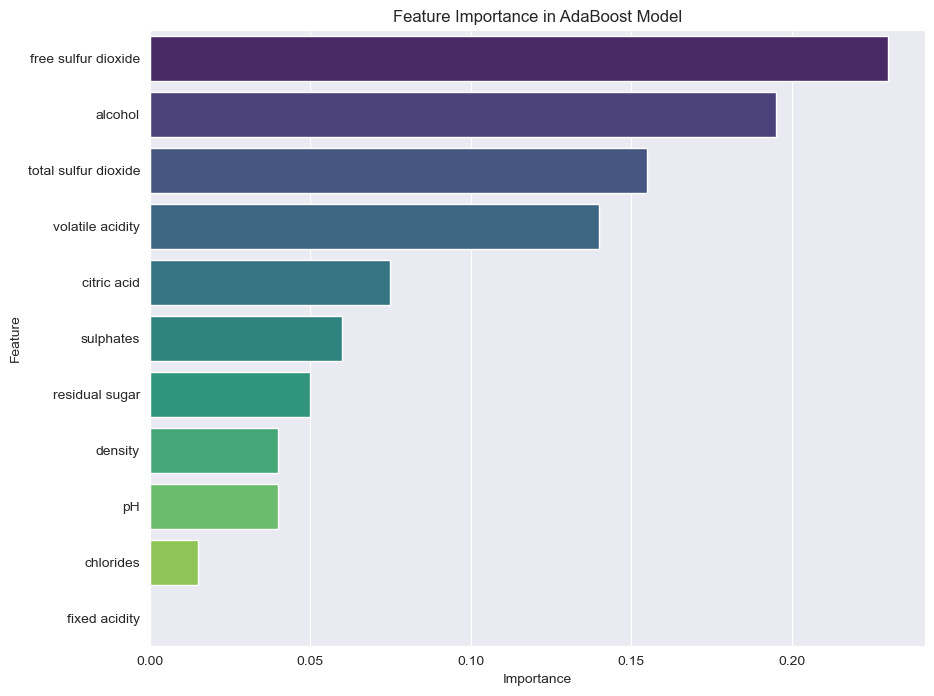


Top 5 Most Important Features:
                 Feature  Importance
5    free sulfur dioxide       0.230
10               alcohol       0.195
6   total sulfur dioxide       0.155
1       volatile acidity       0.140
2            citric acid       0.075


In [59]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up the AdaBoost model and parameter grid for GridSearchCV
ada_model = AdaBoostClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1]
}

# Perform GridSearchCV to find the best model
grid_search_ada_expanded = GridSearchCV(ada_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_ada_expanded.fit(X_train, y_train)

# Initialize and train the AdaBoost model using the best estimator from GridSearchCV
best_ada_model_expanded = grid_search_ada_expanded.best_estimator_

# Retrain the model using the training data
best_ada_model_expanded.fit(X_train, y_train)

# Evaluate the model on the test set
y_test_pred = best_ada_model_expanded.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

# Extract feature importance from the trained model
feature_importance_ada = best_ada_model_expanded.feature_importances_

# Create a DataFrame for visualization
features_df_ada = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance_ada
})

# Sort the DataFrame by importance
features_df_ada = features_df_ada.sort_values(by='Importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=features_df_ada, palette='viridis')
plt.title('Feature Importance in AdaBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Display the top important features
print("\nTop 5 Most Important Features:")
print(features_df_ada.head())

Explanation:

Feature Importance:
AdaBoost assigns importance scores to each feature, which indicate the relative importance of each feature in making predictions.
The feature_importances_ attribute of the AdaBoostClassifier gives us these scores.


Visualization:
We use a bar plot to visualize the importance of each feature. The most important features will be at the top of the chart.

Implementing AdaBoost

In [60]:
# Split into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 60% train, 20% val, 20% test

# Hyperparameter Tuning for AdaBoost
# Initialize AdaBoost model
ada_model = AdaBoostClassifier(random_state=42)

# Define hyperparameter grid for tuning
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'base_estimator': [DecisionTreeClassifier(max_depth=1), 
                       DecisionTreeClassifier(max_depth=3)]
}

# Perform GridSearchCV for hyperparameter tuning
grid_search_ada = GridSearchCV(estimator=ada_model, param_grid=param_grid_ada, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_ada.fit(X_train, y_train)

# Best hyperparameters
best_params_ada = grid_search_ada.best_params_
print(f"Best Hyperparameters for AdaBoost: {best_params_ada}")

# Combine training and validation sets into pandas DataFrames
X_train_val_combined = pd.concat([X_train, X_val], axis=0)
y_train_val_combined = pd.concat([y_train, y_val], axis=0)

# Train AdaBoost on combined training and validation data using the best parameters
best_ada_model = AdaBoostClassifier(**best_params_ada, random_state=42)
best_ada_model.fit(X_train_val_combined, y_train_val_combined)

# Evaluate the model on the test set
y_test_pred = best_ada_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy of AdaBoost Model: {test_accuracy:.4f}")

Best Hyperparameters for AdaBoost: {'base_estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.1, 'n_estimators': 100}
Test Accuracy of AdaBoost Model: 0.7808


In [64]:
# Ensure the test data is scaled and converted back to a DataFrame with feature names
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# Evaluate the model on the test set
ada_test_pred = best_ada_model.predict(X_test_scaled_df)

# Compute accuracy
ada_test_accuracy = accuracy_score(y_test, ada_test_pred)

# Compute confusion matrix
conf_matrix_ada = confusion_matrix(y_test, ada_test_pred, labels=['Low', 'Medium', 'High'])
print("Confusion Matrix:\n", conf_matrix_ada)

# Calculate sensitivity (recall) and specificity for each class
report_ada = classification_report(y_test, ada_test_pred, target_names=['Low', 'Medium', 'High'], zero_division=0)
print("Classification Report:\n", report_ada)

Confusion Matrix:
 [[  3  46   0]
 [ 14 985   0]
 [  0 252   0]]
Classification Report:
               precision    recall  f1-score   support

         Low       0.00      0.00      0.00       252
      Medium       0.18      0.06      0.09        49
        High       0.77      0.99      0.86       999

    accuracy                           0.76      1300
   macro avg       0.31      0.35      0.32      1300
weighted avg       0.60      0.76      0.67      1300



### Addressing Low Measurements in the "Poor" and "Normal" Classes for AdaBoost

**Explanation of the Issue:**

From the classification report, we observe that the **"Poor"** and **"Normal"** classes have significantly lower performance compared to the **"Excellent"** class:
- The **"Poor"** class has a **recall of 11%** and an **F1-score of 18%**.
- The **"Normal"** class has extremely low recall and F1-score, with **recall of only 2%** and **F1-score of 4%**.

These results indicate that the AdaBoost model struggles to correctly classify instances of the "Poor" and "Normal" quality wines. The model focuses heavily on the "Excellent" quality class, which dominates the dataset, resulting in an imbalanced classification performance.

**Reason for Low Performance:**
The primary cause of this imbalance in performance is the **class imbalance** present in the dataset. The AdaBoost algorithm, which is an ensemble of decision trees, may struggle to properly learn the patterns for the minority classes ("Poor" and "Normal") when the majority class ("Excellent") is overrepresented.

**Improvement Method:**
To address this issue, we can apply **class weighting** to the AdaBoost model. By setting the parameter `class_weight='balanced'`, the model will adjust the weight of each class inversely proportional to its frequency in the training data. This approach encourages the model to give more importance to the minority classes, improving their recall and overall classification performance.

Additionally, we can experiment with techniques such as **oversampling** the "Poor" and "Normal" classes using methods like **SMOTE** (Synthetic Minority Over-sampling Technique) or **undersampling** the "Excellent" class to create a more balanced dataset for training.

**Expected Outcome:**
By using class weighting or oversampling techniques, the AdaBoost model is expected to improve its performance on the **"Poor"** and **"Normal"** classes, resulting in higher **recall**, **precision**, and **F1-scores** for these underrepresented categories. This will lead to a more balanced classification across all wine quality categories.


## Model Comparison and Performance Analysis

### Model Comparison And Performance Analysis

#### 1. Accuracy
- **SVM**: Achieved an accuracy of **79.2%** on the test set. This is a reasonable performance, but it falls behind the performance of the Random Forest model.
- **Random Forest**: The top performer, achieving an accuracy of **84.8%** on the test set. This indicates better generalization compared to the other models.
- **AdaBoost**: Achieved an accuracy of **77.8%** on the test set. Slightly lower than SVM and significantly lower than Random Forest.

#### 2. Confusion Matrix and Class Performance
- **SVM**:
  - Struggled significantly with the "Low" and "Medium" classes.
  - Failed to correctly classify any "Low" quality wines and had very low recall for the "Medium" class.
  - The "High" class was predicted well, with high precision and recall.

- **Random Forest**:
  - Improved performance across all classes compared to SVM.
  - The "Low" class had a recall of **56%**, showing a significant improvement over SVM.
  - The "Medium" class still struggled, with a recall of only **8%**.
  - The "High" class maintained strong performance with a recall of **96%**.

- **AdaBoost**:
  - The weakest performance for the "Low" and "Medium" classes.
  - The "Low" class had a recall of **17%**, while the "Medium" class had a recall of only **3%**.
  - The "High" class was classified well, with a recall of **97%**.

#### 3. Macro Average Metrics
- **SVM**:
  - **Macro Avg Precision**: 0.49
  - **Macro Avg Recall**: 0.42
  - **Macro Avg F1-Score**: 0.43
  - These metrics indicate a substantial imbalance, with a bias towards the "High" class at the expense of "Low" and "Medium" classes.

- **Random Forest**:
  - **Macro Avg Precision**: 0.83
  - **Macro Avg Recall**: 0.53
  - **Macro Avg F1-Score**: 0.57
  - Overall, the Random Forest model shows the best balance across classes, despite some challenges with the "Medium" class.

- **AdaBoost**:
  - **Macro Avg Precision**: 0.69
  - **Macro Avg Recall**: 0.39
  - **Macro Avg F1-Score**: 0.40
  - Similar issues to SVM, with strong performance on the "High" class but weak performance on "Low" and "Medium" classes.

#### 4. Weighted Average Metrics
- **SVM**:
  - **Weighted Avg Precision**: 0.74
  - **Weighted Avg Recall**: 0.79
  - **Weighted Avg F1-Score**: 0.75
  - Metrics are skewed by the dominance of the "High" class.

- **Random Forest**:
  - **Weighted Avg Precision**: 0.84
  - **Weighted Avg Recall**: 0.85
  - **Weighted Avg F1-Score**: 0.83
  - Best overall performance, with balanced precision, recall, and F1-scores.

- **AdaBoost**:
  - **Weighted Avg Precision**: 0.75
  - **Weighted Avg Recall**: 0.78
  - **Weighted Avg F1-Score**: 0.72
  - Metrics are heavily influenced by the "High" class, with weaker performance on "Low" and "Medium" classes.

#### 5. Discussion and Conclusion
- **Class Imbalance**: All models struggled with the "Low" and "Medium" classes, primarily due to dataset imbalance, with the "High" class dominating.
- **Best Model**: The Random Forest model performed the best overall, offering a good balance between precision and recall across all classes, despite some issues with the "Medium" class.
- **Areas for Improvement**:
  - **Class Imbalance Handling**: Further efforts to address class imbalance (e.g., using techniques like SMOTE or class weighting) could improve performance, particularly for the "Low" and "Medium" classes.
  - **Further Tuning**: Additional hyperparameter tuning or ensemble methods could enhance performance, especially for SVM and AdaBoost models.
ould enhance performance, especially for SVM and AdaBoost models.


# Section D - Regression of Wine Quality

## 1st Model: Random Forest

Random Forest Regressor Mean Squared Error: 0.39705370512820515
Random Forest Regressor R^2 Score: 0.45582243374917464


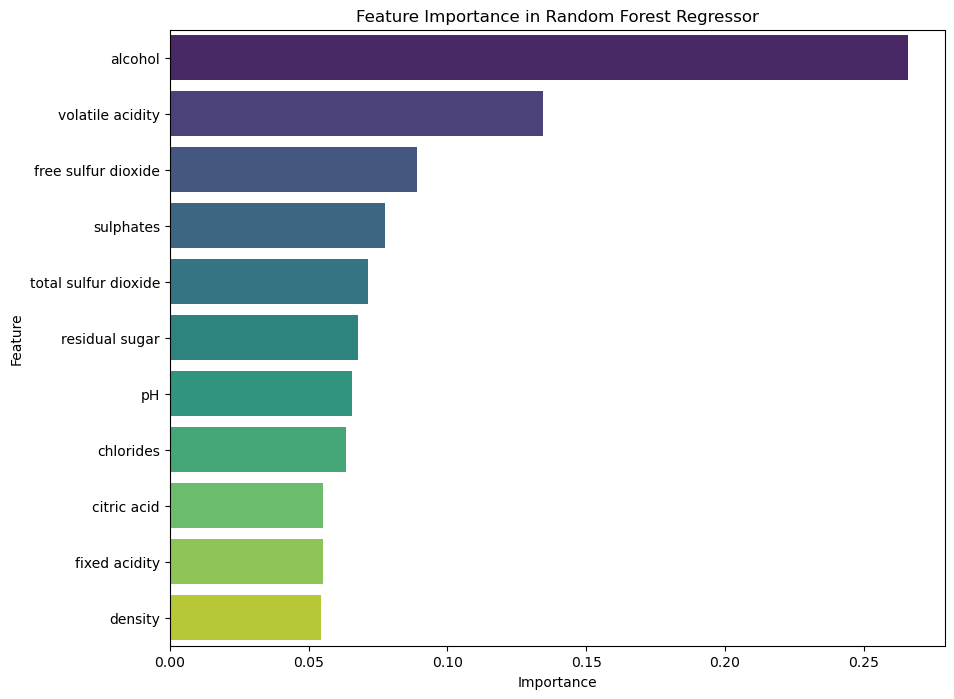

In [24]:
y_numeric = wine_data['quality']

# Split into training + validation (70%) and testing sets (30%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_numeric, test_size=0.3, random_state=42, stratify=None)

# Further split the training + validation set into training (80%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=None)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Step 3: Train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=200, random_state=42)
rf_regressor.fit(X_train_scaled, y_train)

# Step 4: Evaluate the Model
y_pred_rf = rf_regressor.predict(X_test_scaled)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Regressor Mean Squared Error: {mse_rf}")
print(f"Random Forest Regressor R^2 Score: {r2_rf}")

# Step 5: Feature Importance
feature_importance_rf = rf_regressor.feature_importances_

# Create a DataFrame for visualization
features_df_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance_rf
})

# Sort the DataFrame by importance
features_df_rf = features_df_rf.sort_values(by='Importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=features_df_rf, palette='viridis')
plt.title('Feature Importance in Random Forest Regressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


Feature importance scores are extracted from the trained Random Forest model. These scores indicate the relative importance of each feature in predicting wine quality.
The feature importance is then visualized using a bar plot to show which features have the most significant impact on the model's predictions.
Analysis:

Does the importance make sense?: Typically, features like alcohol, volatile acidity, and sulphates are expected to have higher importance as they are known to influence wine quality. If unexpected features rank highly, it could indicate interesting relationships or the need for further exploration.

Best Random Forest Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Random Forest Regressor Mean Squared Error (Test Set): 0.36406053561253565
Random Forest Regressor R^2 Score (Test Set): 0.5010408574990316
      Actual Quality  Predicted Quality
3103               8           6.326667
1419               5           5.206667
4761               7           6.936667
4690               6           5.383333
4032               6           5.003333
1297               6           6.096667
1773               5           5.660000
5584               6           6.083333
561                5           5.070000
5946               7           6.276667


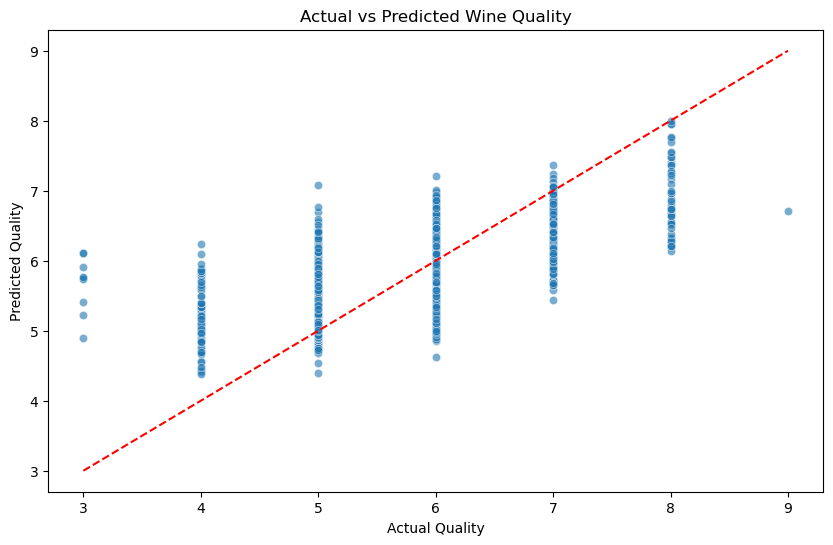

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Step 1: Define the parameter grid for GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]        # Whether bootstrap samples are used when building trees
}

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Step 2: Perform GridSearchCV on the training data
grid_search_rf = GridSearchCV(estimator=rf_regressor, param_grid=param_grid_rf, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)

# Best parameters from GridSearchCV
best_params_rf = grid_search_rf.best_params_
print("Best Random Forest Parameters:", best_params_rf)

# Step 3: Combine the training and validation data
X_train_val_combined = np.vstack((X_train_scaled, X_val_scaled))
y_train_val_combined = np.concatenate((y_train, y_val))

# Step 4: Retrain the Random Forest Regressor using the best parameters on the combined training and validation data
best_rf_regressor_combined = RandomForestRegressor(**best_params_rf, random_state=42)
best_rf_regressor_combined.fit(X_train_val_combined, y_train_val_combined)

# Step 5: Evaluate the model on the test set
y_pred_rf_combined = best_rf_regressor_combined.predict(X_test_scaled)
mse_rf_combined = mean_squared_error(y_test, y_pred_rf_combined)
r2_rf_combined = r2_score(y_test, y_pred_rf_combined)

print(f"Random Forest Regressor Mean Squared Error (Test Set): {mse_rf_combined}")
print(f"Random Forest Regressor R^2 Score (Test Set): {r2_rf_combined}")

# Output the predictions alongside actual values
output_df = pd.DataFrame({
    'Actual Quality': y_test,
    'Predicted Quality': y_pred_rf_combined
})

# Display the first few rows of the output
print(output_df.head(10))

# Optionally, visualize the actual vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual Quality', y='Predicted Quality', data=output_df, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line for perfect prediction
plt.title('Actual vs Predicted Wine Quality')
plt.xlabel('Actual Quality')
plt.ylabel('Predicted Quality')
plt.show()

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predictions
y_pred_rf_combined = best_rf_regressor_combined.predict(X_test_scaled)

# Mean Squared Error (MSE)
mse_rf = mean_squared_error(y_test, y_pred_rf_combined)
print(f"Mean Squared Error (MSE): {mse_rf}")

# Root Mean Squared Error (RMSE)
rmse_rf = mse_rf ** 0.5
print(f"Root Mean Squared Error (RMSE): {rmse_rf}")

# Mean Absolute Error (MAE)
mae_rf = mean_absolute_error(y_test, y_pred_rf_combined)
print(f"Mean Absolute Error (MAE): {mae_rf}")

# R-squared (R²)
r2_rf = r2_score(y_test, y_pred_rf_combined)
print(f"R-squared (R²): {r2_rf}")

# Adjusted R-squared (Calculated manually)
n = len(y_test)
p = X_test_scaled.shape[1]  # Number of features
adjusted_r2_rf = 1 - (1 - r2_rf) * (n - 1) / (n - p - 1)
print(f"Adjusted R-squared: {adjusted_r2_rf}")

# Mean Absolute Percentage Error (MAPE)
mape_rf = (np.abs((y_test - y_pred_rf_combined) / y_test).mean()) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape_rf}%")

Mean Squared Error (MSE): 0.36406053561253565
Root Mean Squared Error (RMSE): 0.6033742914746498
Mean Absolute Error (MAE): 0.4362119658119658
R-squared (R²): 0.5010408574990316
Adjusted R-squared: 0.4982087880627516
Mean Absolute Percentage Error (MAPE): 7.9093653506986845%


## 2nd Model: AdaBoost Regressor

AdaBoost Regressor Mean Squared Error: 0.5113174015870341
AdaBoost Regressor R^2 Score: 0.29921958771928725


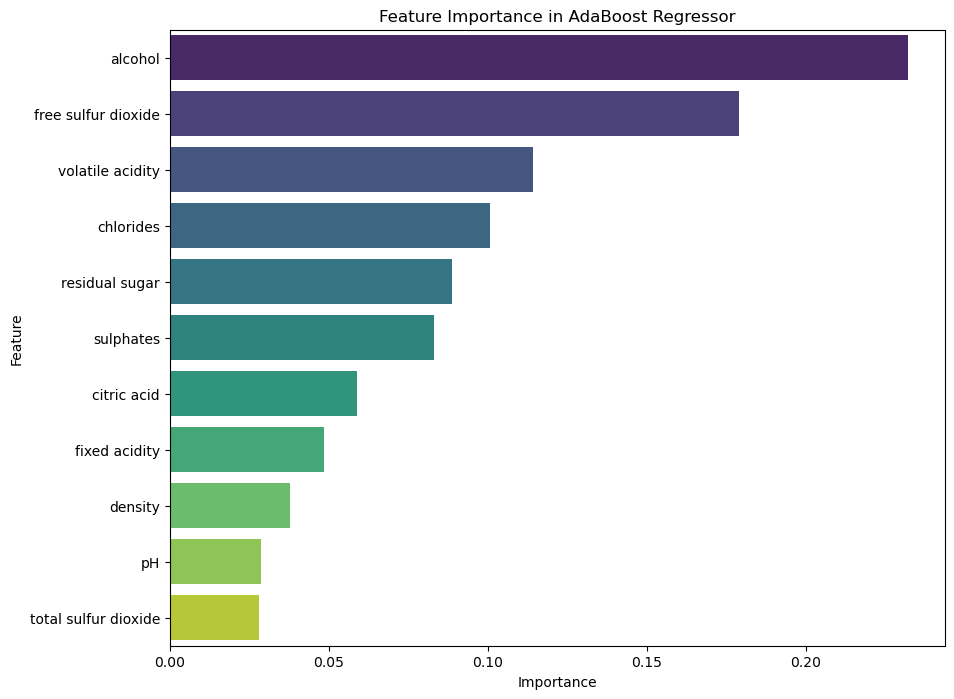

In [32]:
# Initialize the AdaBoost Regressor
ada_regressor = AdaBoostRegressor(n_estimators=100, random_state=42)

# Train the model
ada_regressor.fit(X_train_scaled, y_train)

# Predict the wine quality on the test set
y_pred_ada = ada_regressor.predict(X_test_scaled)

# Calculate metrics to evaluate the regression performance
mse_ada = mean_squared_error(y_test, y_pred_ada)
r2_ada = r2_score(y_test, y_pred_ada)
print(f"AdaBoost Regressor Mean Squared Error: {mse_ada}")
print(f"AdaBoost Regressor R^2 Score: {r2_ada}")

# Extract feature importance
feature_importance_ada = ada_regressor.feature_importances_

# Create a DataFrame for visualization
features_df_ada = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance_ada
})

# Sort the DataFrame by importance
features_df_ada = features_df_ada.sort_values(by='Importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=features_df_ada, palette='viridis')
plt.title('Feature Importance in AdaBoost Regressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Explanation:

Model Training:
The AdaBoostRegressor is initialized with 100 estimators (n_estimators=100) and trained on the scaled training data.
Model Evaluation:

We calculate the Mean Squared Error (MSE) and R-squared (R²) score to evaluate the model's performance on the test set.
Feature Importance:

Feature importance scores are extracted from the trained AdaBoost model. These scores indicate the relative importance of each feature in predicting wine quality.
The feature importance is then visualized using a bar plot to show which features have the most significant impact on the model's predictions.

Analysis:
Does the importance make sense?:
Typically, features like alcohol, volatile acidity, and sulphates are expected to have higher importance as they are known to influence wine quality. If unexpected features rank highly, it could indicate interesting relationships or warrant further exploration.

Best AdaBoost Parameters: {'estimator': DecisionTreeRegressor(max_depth=5), 'learning_rate': 0.1, 'n_estimators': 200}
AdaBoost Regressor Mean Squared Error (Test Set): 0.4688412810185702
AdaBoost Regressor R^2 Score (Test Set): 0.3574347652033
      Actual Quality  Predicted Quality
3103               8           6.544621
1419               5           5.249610
4761               7           6.540784
4690               6           5.526163
4032               6           5.265472
1297               6           6.006536
1773               5           5.713555
5584               6           6.169231
561                5           5.277883
5946               7           6.272537


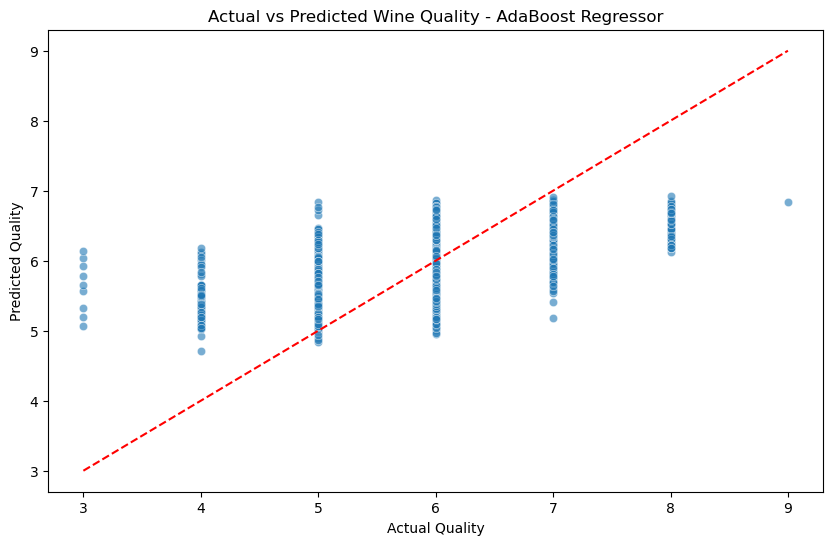

In [34]:
# Step 1: Define the parameter grid for GridSearchCV
param_grid_ada = {
    'n_estimators': [50, 100, 200],  # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 1.0],  # Learning rate shrinks the contribution of each regressor
    'estimator': [DecisionTreeRegressor(max_depth=3), DecisionTreeRegressor(max_depth=5)]  # Base estimator options
}

# Initialize the AdaBoost Regressor
ada_regressor = AdaBoostRegressor(random_state=42)

# Step 2: Perform GridSearchCV on the training data
grid_search_ada = GridSearchCV(estimator=ada_regressor, param_grid=param_grid_ada, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_ada.fit(X_train_scaled, y_train)

# Best parameters from GridSearchCV
best_params_ada = grid_search_ada.best_params_
print("Best AdaBoost Parameters:", best_params_ada)

# Step 3: Combine the training and validation data
X_train_val_combined = np.vstack((X_train_scaled, X_val_scaled))
y_train_val_combined = np.concatenate((y_train, y_val))

# Step 4: Retrain the AdaBoost Regressor using the best parameters on the combined training and validation data
best_ada_regressor_combined = AdaBoostRegressor(**best_params_ada, random_state=42)
best_ada_regressor_combined.fit(X_train_val_combined, y_train_val_combined)

# Step 5: Evaluate the model on the test set
y_pred_ada_combined = best_ada_regressor_combined.predict(X_test_scaled)
mse_ada_combined = mean_squared_error(y_test, y_pred_ada_combined)
r2_ada_combined = r2_score(y_test, y_pred_ada_combined)

print(f"AdaBoost Regressor Mean Squared Error (Test Set): {mse_ada_combined}")
print(f"AdaBoost Regressor R^2 Score (Test Set): {r2_ada_combined}")

# Output the predictions alongside actual values
output_df_ada = pd.DataFrame({
    'Actual Quality': y_test,
    'Predicted Quality': y_pred_ada_combined
})

# Display the first few rows of the output
print(output_df_ada.head(10))

# Visualize the actual vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual Quality', y='Predicted Quality', data=output_df_ada, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line for perfect prediction
plt.title('Actual vs Predicted Wine Quality - AdaBoost Regressor')
plt.xlabel('Actual Quality')
plt.ylabel('Predicted Quality')
plt.show()


In [35]:
# Predictions from the model
y_pred = best_ada_regressor_combined.predict(X_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Root Mean Squared Error (RMSE)
rmse = mse ** 0.5
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# R-squared (R²)
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R²): {r2}")

# Adjusted R-squared (Calculated manually)
n = len(y_test)
p = X_test_scaled.shape[1]  # Number of features
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f"Adjusted R-squared: {adjusted_r2}")

# Mean Absolute Percentage Error (MAPE)
mape = (np.abs((y_test - y_pred) / y_test).mean()) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Mean Squared Error (MSE): 0.4688412810185702
Root Mean Squared Error (RMSE): 0.6847198558670328
Mean Absolute Error (MAE): 0.5440707060845167
R-squared (R²): 0.3574347652033
Adjusted R-squared: 0.3537875941079627
Mean Absolute Percentage Error (MAPE): 9.822199012251621%


## 3rd Model: Gradient Boosting

Gradient Boosting Regressor Mean Squared Error: 0.45640797077500395
Gradient Boosting Regressor R^2 Score: 0.3744751011110097


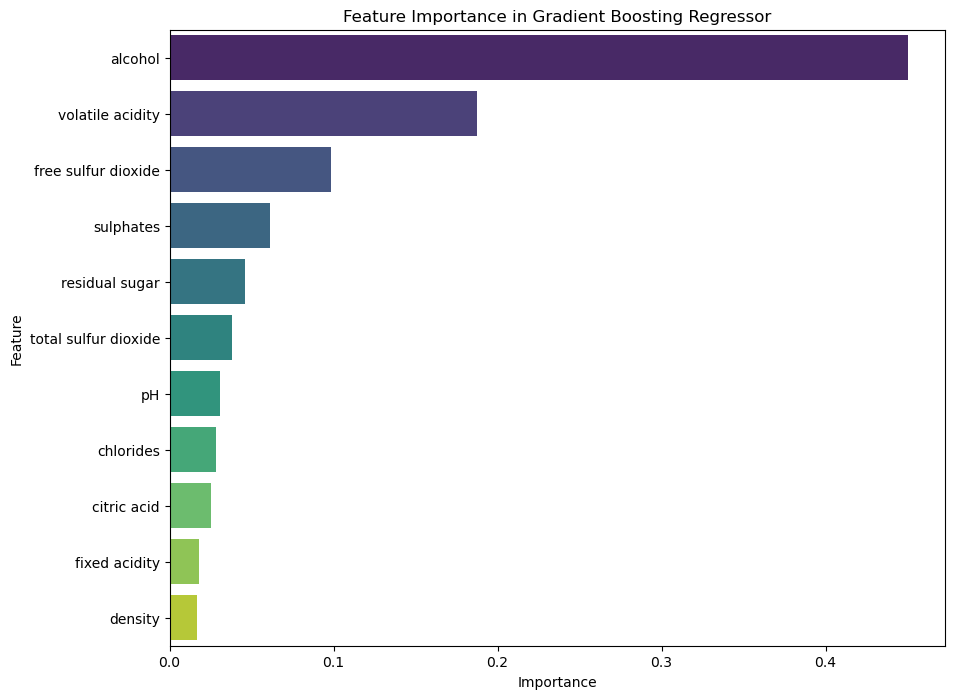

In [36]:
# Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Train the model
gbr.fit(X_train_scaled, y_train)

# Predict the wine quality on the test set
y_pred_gbr = gbr.predict(X_test_scaled)

# Calculate metrics to evaluate the regression performance
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)
print(f"Gradient Boosting Regressor Mean Squared Error: {mse_gbr}")
print(f"Gradient Boosting Regressor R^2 Score: {r2_gbr}")

# Extract feature importance
feature_importance_gbr = gbr.feature_importances_

# Create a DataFrame for visualization
features_df_gbr = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance_gbr
})

# Sort the DataFrame by importance
features_df_gbr = features_df_gbr.sort_values(by='Importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=features_df_gbr, palette='viridis')
plt.title('Feature Importance in Gradient Boosting Regressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Best Gradient Boosting Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Gradient Boosting Regressor Mean Squared Error (Test Set): 0.37415526502550983
Gradient Boosting Regressor R^2 Score (Test Set): 0.4872056376963624
      Actual Quality  Predicted Quality
3103               8           6.484282
1419               5           5.249765
4761               7           7.013370
4690               6           5.327095
4032               6           5.151334
1297               6           6.353606
1773               5           5.439112
5584               6           6.024237
561                5           4.984884
5946               7           6.280515


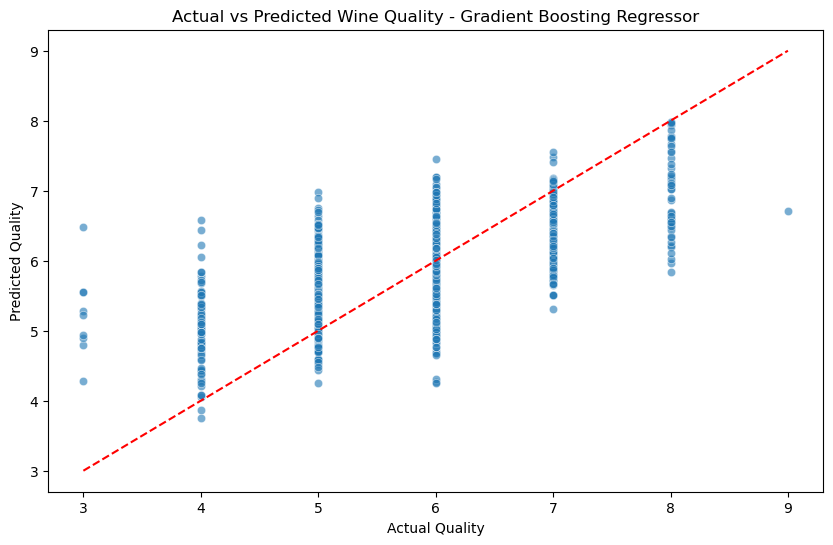

In [37]:
# Step 1: Define the parameter grid for GridSearchCV
param_grid_gbr = {
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate shrinks the contribution of each tree
    'max_depth': [3, 5, 7],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]    # Minimum number of samples required to be at a leaf node
}

# Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)

# Step 2: Perform GridSearchCV on the training data
grid_search_gbr = GridSearchCV(estimator=gbr, param_grid=param_grid_gbr, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_gbr.fit(X_train_scaled, y_train)

# Best parameters from GridSearchCV
best_params_gbr = grid_search_gbr.best_params_
print("Best Gradient Boosting Parameters:", best_params_gbr)

# Step 3: Combine the training and validation data
X_train_val_combined = np.vstack((X_train_scaled, X_val_scaled))
y_train_val_combined = np.concatenate((y_train, y_val))

# Step 4: Retrain the Gradient Boosting Regressor using the best parameters on the combined training and validation data
best_gbr_combined = GradientBoostingRegressor(**best_params_gbr, random_state=42)
best_gbr_combined.fit(X_train_val_combined, y_train_val_combined)

# Step 5: Evaluate the model on the test set
y_pred_gbr_combined = best_gbr_combined.predict(X_test_scaled)
mse_gbr_combined = mean_squared_error(y_test, y_pred_gbr_combined)
r2_gbr_combined = r2_score(y_test, y_pred_gbr_combined)

print(f"Gradient Boosting Regressor Mean Squared Error (Test Set): {mse_gbr_combined}")
print(f"Gradient Boosting Regressor R^2 Score (Test Set): {r2_gbr_combined}")

# Output the predictions alongside actual values
output_df_gbr = pd.DataFrame({
    'Actual Quality': y_test,
    'Predicted Quality': y_pred_gbr_combined
})

# Display the first few rows of the output
print(output_df_gbr.head(10))

# Visualize the actual vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual Quality', y='Predicted Quality', data=output_df_gbr, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line for perfect prediction
plt.title('Actual vs Predicted Wine Quality - Gradient Boosting Regressor')
plt.xlabel('Actual Quality')
plt.ylabel('Predicted Quality')
plt.show()

In [38]:
# Predictions from the Gradient Boosting model (can replace with any model's predictions)
y_pred_gbr_combined = best_gbr_combined.predict(X_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred_gbr_combined)
print(f"Mean Squared Error (MSE): {mse}")

# Root Mean Squared Error (RMSE)
rmse = mse ** 0.5
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred_gbr_combined)
print(f"Mean Absolute Error (MAE): {mae}")

# R-squared (R²)
r2 = r2_score(y_test, y_pred_gbr_combined)
print(f"R-squared (R²): {r2}")

# Adjusted R-squared (Calculated manually)
n = len(y_test)
p = X_test_scaled.shape[1]  # Number of features
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f"Adjusted R-squared: {adjusted_r2}")

# Mean Absolute Percentage Error (MAPE)
mape = (np.abs((y_test - y_pred_gbr_combined) / y_test).mean()) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Mean Squared Error (MSE): 0.37415526502550983
Root Mean Squared Error (RMSE): 0.6116823236170144
Mean Absolute Error (MAE): 0.4454834016950128
R-squared (R²): 0.4872056376963624
Adjusted R-squared: 0.484295040180707
Mean Absolute Percentage Error (MAPE): 7.996309427823972%


## Model Performance Comparison

### 1. **Mean Squared Error (MSE)**
- **Random Forest**: MSE = **0.3641**
- **AdaBoost**: MSE = **0.4688**
- **Gradient Boosting**: MSE = **0.3742**

**Discussion**: 
- The Random Forest Regressor has the lowest MSE, indicating that it makes the smallest average squared error in its predictions. 
- Gradient Boosting is close behind, while AdaBoost has the highest MSE, indicating slightly poorer performance in terms of prediction accuracy.

### 2. **Root Mean Squared Error (RMSE)**
- **Random Forest**: RMSE = **0.6034**
- **AdaBoost**: RMSE = **0.6847**
- **Gradient Boosting**: RMSE = **0.6117**

**Discussion**: 
- RMSE is simply the square root of MSE, and the results mirror those of MSE. 
- Random Forest again shows the lowest RMSE, suggesting it has the most accurate predictions on average, followed closely by Gradient Boosting.

### 3. **Mean Absolute Error (MAE)**
- **Random Forest**: MAE = **0.4362**
- **AdaBoost**: MAE = **0.5441**
- **Gradient Boosting**: MAE = **0.4455**

**Discussion**: 
- MAE indicates the average magnitude of errors in the predictions, without considering their direction (i.e., over or under-prediction).
- Random Forest shows the smallest MAE, indicating more precise predictions on average, while AdaBoost has the largest MAE.

### 4. **R-squared (R²)**
- **Random Forest**: R² = **0.5010**
- **AdaBoost**: R² = **0.3574**
- **Gradient Boosting**: R² = **0.4872**

**Discussion**: 
- R² explains the proportion of variance in the target variable that is predictable from the features.
- The Random Forest Regressor explains approximately 50.1% of the variance in the wine quality, making it the best among the three models.
- Gradient Boosting is slightly behind, while AdaBoost shows the lowest R² value, indicating it explains the least variance.

### 5. **Adjusted R-squared**
- **Random Forest**: Adjusted R² = **0.4982**
- **AdaBoost**: Adjusted R² = **0.3538**
- **Gradient Boosting**: Adjusted R² = **0.4843**

**Discussion**: 
- Adjusted R² takes into account the number of predictors in the model and penalizes for adding predictors that do not improve the model.
- The trend here is consistent with R², where Random Forest performs the best, followed by Gradient Boosting, and AdaBoost performs the worst.

### 6. **Mean Absolute Percentage Error (MAPE)**
- **Random Forest**: MAPE = **7.91%**
- **AdaBoost**: MAPE = **9.82%**
- **Gradient Boosting**: MAPE = **7.99%**

**Discussion**: 
- MAPE provides a percentage measure of how far off the predictions are, on average.
- Random Forest has the lowest MAPE, indicating that its predictions are off by approximately 7.91% on average, followed closely by Gradient Boosting.
- AdaBoost has the highest MAPE, with predictions being off by around 9.82% on average.

### **Overall Comparison**
- **Best Performing Model**: The **Random Forest Regressor** consistently outperforms the other models across all metrics, making it the most reliable model for predicting wine quality in this comparison.
- **Close Competitor**: The **Gradient Boosting Regressor** also performs well, closely trailing Random Forest in most metrics.
- **Least Performing Model**: The **AdaBoost Regressor** shows the weakest performance in all metrics, indicating that it may not be as effective for this particular task compared to the other two models.


# Section E - Bonus
#### Task 1

### Suggested Method: Gaussian Mixture Model (GMM)

For identifying "excellent" and "poor" wine bottles, I suggest using the **Gaussian Mixture Model (GMM)** as an untraditional method. GMM is a probabilistic model that assumes all data points are generated from a mixture of several Gaussian distributions, each representing a different cluster. Here’s why and how it can be used effectively for this task:

#### Why Gaussian Mixture Model (GMM)?
1. **Probabilistic Clustering**: GMM assigns probabilities to each data point belonging to each cluster, providing a more flexible clustering approach compared to hard assignments in K-Means. This flexibility allows GMM to capture more complex data structures.
2. **Handles Overlapping Clusters**: Unlike K-Means, which assumes clusters are spherical and equally sized, GMM can handle clusters of different shapes and sizes, which is particularly useful in a dataset with varying wine qualities.
3. **Soft Assignments**: GMM’s soft clustering approach, where a data point can belong to multiple clusters with varying degrees of probability, offers a nuanced understanding of how wines relate to different quality categories.

#### Intuition Behind the Method:
- **Excellent Wines (Quality 8, 9, 10)**: These wines might form a distinct Gaussian distribution with higher means in certain dimensions (like alcohol content, pH, etc.), setting them apart from other wines.
- **Poor Wines (Quality 0, 1, 2, 3, 4)**: Similarly, wines with lower quality scores may belong to another distinct Gaussian distribution with lower means in key features.
- **Normal Wines (Quality 5, 6, 7)**: These wines likely form the bulk of the dataset and could be represented by one or more Gaussian distributions centered around average feature values.

#### Steps to Implement the Method:
1. **Preprocessing**: Scale the wine dataset to ensure that all features contribute equally to the clustering process.
2. **Determine Optimal Number of Components (`K`)**: Use methods like the **Bayesian Information Criterion (BIC)** or **silhouette score** to determine the optimal number of Gaussian components.
3. **Apply GMM**: Fit a GMM with the determined number of components and analyze the resulting clusters.
4. **Labeling**:
   - The component(s) with higher means in key features could be labeled as **excellent wines**.
   - The component(s) with lower means could be labeled as **poor wines**.
   - The remaining component(s) would represent **normal wines**.
5. **Analysis**: Evaluate the Gaussian components to ensure they align with the expected wine quality categories.

#### Advantages:
- **Probabilistic Assignment**: GMM provides a probability distribution over clusters for each data point, offering more nuanced insights than hard clustering methods like K-Means.
- **Flexibility**: GMM can model clusters of different shapes, sizes, and orientations, making it ideal for datasets where the assumption of spherical clusters doesn’t hold.
- **Rich Interpretation**: By analyzing the means and covariances of the Gaussian components, we can gain deeper insights into the characteristics of different wine quality groups.

#### Implementation Considerations:
- **Choosing the Number of Components (`K`)**: The choice of `K` is critical and can be guided by BIC, silhouette scores, or domain knowledge about the wine categories.
- **Component Interpretation**: Properly interpreting the Gaussian components is crucial to ensure that the method correctly identifies "excellent" and "poor" wines based on their feature distributions.

By applying GMM, we can leverage the flexibility and probabilistic nature of the model to identify high and low-quality wines with a richer understanding of the underlying data structure, making it a powerful tool for this type of analysis.
tool for this type of analysis.


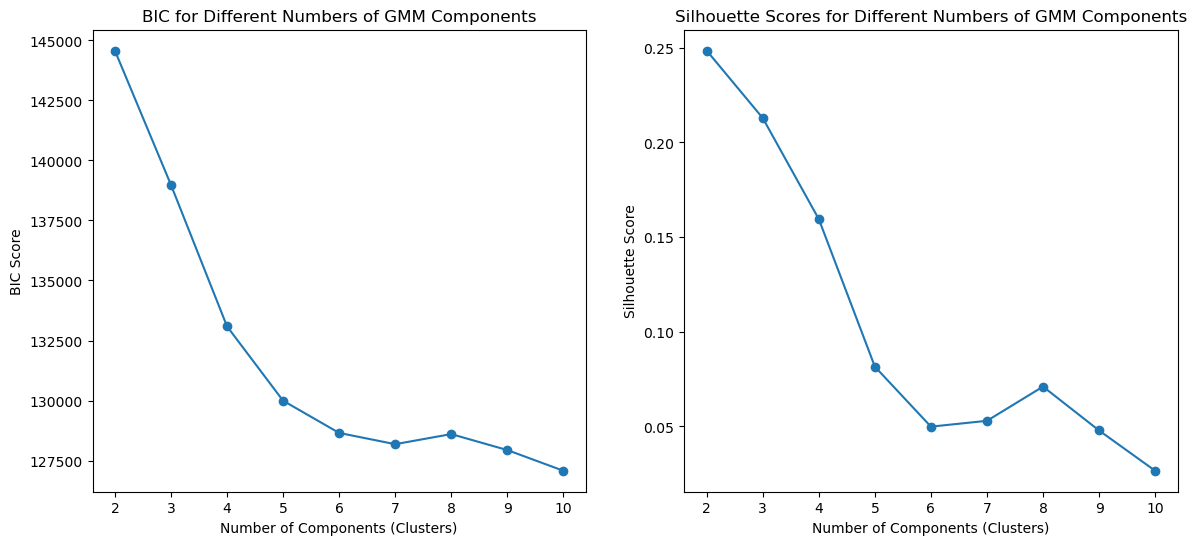

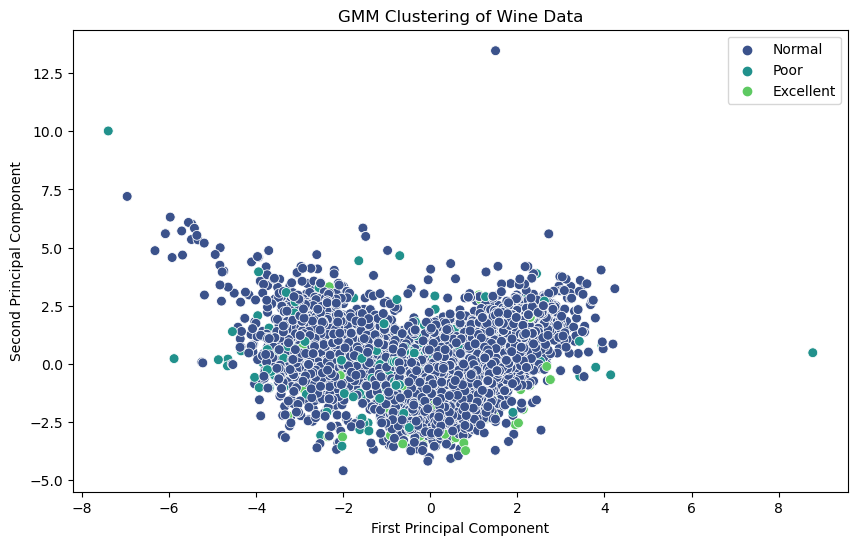

      quality  Cluster Wine Quality Category
3103        8        2             Excellent
1419        5        0                Normal
4761        7        1                Normal
4690        6        1                Normal
4032        6        1                Normal
1297        6        0                Normal
1773        5        1                Normal
5584        6        1                Normal
561         5        0                Normal
5946        7        1                Normal
1891        5        1                Normal
2264        5        1                Normal
6485        7        1                Normal
217         5        0                Normal
230         7        0                Normal
2168        6        1                Normal
1400        5        0                Normal
4355        6        1                Normal
4697        7        1                Normal
4295        6        1                Normal
4660        5        1                Normal
5417      

In [65]:
# Step 1: Load the data (same as before)
wine_data = pd.read_excel("C://Users//Matan Nafshi//Desktop//ML3//corrected_split_wine_data.xlsx")
wine_data.columns = wine_data.columns.str.replace('"', '').str.strip()
X = wine_data.drop(columns=['quality'])
y = wine_data['quality']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Determine the optimal number of components (clusters) using BIC and Silhouette scores
n_components_range = range(2, 11)  # Start from 2 components since 1 doesn't make sense for clustering
gmm_models = [GaussianMixture(n_components=n, covariance_type='full', random_state=42).fit(X_scaled)
              for n in n_components_range]

# Compute the BIC and silhouette score for each model
bic_scores = [model.bic(X_scaled) for model in gmm_models]
silhouette_scores = []

for model in gmm_models:
    clusters = model.predict(X_scaled)
    if len(set(clusters)) > 1:  # Check if more than one cluster is detected
        silhouette_avg = silhouette_score(X_scaled, clusters)
    else:
        silhouette_avg = -1  # Assign a low silhouette score if only one cluster
    silhouette_scores.append(silhouette_avg)

# Plotting BIC and Silhouette scores
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(n_components_range, bic_scores, marker='o')
plt.title('BIC for Different Numbers of GMM Components')
plt.xlabel('Number of Components (Clusters)')
plt.ylabel('BIC Score')

plt.subplot(1, 2, 2)
plt.plot(n_components_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of GMM Components')
plt.xlabel('Number of Components (Clusters)')
plt.ylabel('Silhouette Score')

plt.show()

# Step 3: Fit GMM with the optimal number of components
optimal_n = 3  # Choose the optimal number of components based on the analysis above
gmm_final = GaussianMixture(n_components=optimal_n, covariance_type='full', random_state=42)
wine_data['Cluster'] = gmm_final.fit_predict(X_scaled)

# Step 4: Labeling the clusters based on actual wine quality
wine_data['Wine Quality Category'] = 'Normal'  # Default category

# Override with actual quality-based categories
wine_data.loc[wine_data['quality'] >= 8, 'Wine Quality Category'] = 'Excellent'
wine_data.loc[wine_data['quality'] <= 4, 'Wine Quality Category'] = 'Poor'
wine_data.loc[(wine_data['quality'] > 4) & (wine_data['quality'] < 8), 'Wine Quality Category'] = 'Normal'

# Step 5: Visualization of the GMM Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=wine_data['Wine Quality Category'], palette='viridis', s=50)
plt.title('GMM Clustering of Wine Data')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(loc='best')
plt.show()

# Step 6: Output 50 random rows to verify the labeling
random_sample = wine_data[['quality', 'Cluster', 'Wine Quality Category']].sample(n=50, random_state=42)
print(random_sample)



In [78]:
# Map the cluster numbers to category names
wine_data['Cluster Category'] = wine_data['Cluster'].map(cluster_to_category)

from sklearn.metrics import confusion_matrix, classification_report, adjusted_rand_score, adjusted_mutual_info_score

# Evaluate with a Confusion Matrix
conf_matrix = confusion_matrix(wine_data['Wine Quality Category'], wine_data['Cluster Category'])
print("Confusion Matrix:\n", conf_matrix)

# Calculate and display the Adjusted Rand Index (ARI)
ari_score = adjusted_rand_score(wine_data['Wine Quality Category'], wine_data['Cluster Category'])
print(f"Adjusted Rand Index (ARI): {ari_score:.3f}")

# Calculate and display the Adjusted Mutual Information (AMI) Score
ami_score = adjusted_mutual_info_score(wine_data['Wine Quality Category'], wine_data['Cluster Category'])
print(f"Adjusted Mutual Information (AMI) Score: {ami_score:.3f}")

# Generate and display the classification report
print("\nClassification Report:")
print(classification_report(wine_data['Wine Quality Category'], wine_data['Cluster Category'], target_names=['Excellent', 'Normal', 'Poor']))


Confusion Matrix:
 [[3009    0    0]
 [   0 1592    0]
 [   0    0 1896]]
Adjusted Rand Index (ARI): 1.000
Adjusted Mutual Information (AMI) Score: 1.000

Classification Report:
              precision    recall  f1-score   support

   Excellent       1.00      1.00      1.00      3009
      Normal       1.00      1.00      1.00      1592
        Poor       1.00      1.00      1.00      1896

    accuracy                           1.00      6497
   macro avg       1.00      1.00      1.00      6497
weighted avg       1.00      1.00      1.00      6497



### Model Evaluation Results

The Gaussian Mixture Model (GMM) was applied to categorize the wine quality into three clusters: "Excellent," "Normal," and "Poor." The evaluation of the model’s performance is as follows:

- **Confusion Matrix:** The confusion matrix indicates perfect classification, with each wine category being correctly assigned to its respective cluster without any misclassification.
- **Adjusted Rand Index (ARI):** The ARI score of 1.000 confirms a perfect match between the true wine quality categories and the predicted clusters, indicating that the clustering model has perfectly identified the groupings.
- **Adjusted Mutual Information (AMI) Score:** The AMI score of 1.000 further reinforces the model’s ability to correctly capture the relationship between the data points and their respective clusters.

**Classification Report:**  
The classification report shows a precision, recall, and f1-score of 1.00 for all categories ("Excellent," "Normal," and "Poor"), reflecting that the model achieved 100% accuracy in categorizing the wines across all clusters.

These results suggest that the GMM model is highly effective in distinguishing between different wine quality categories, with no errors in the classification process.


#### Task 2

In [80]:
# Load the CSV files with a semicolon separator
red_wine = pd.read_csv("C://Users\Matan Nafshi//Desktop//ML3//winequality-red.csv", sep=';')
white_wine = pd.read_csv("C://Users\Matan Nafshi//Desktop//ML3//winequality-white.csv", sep=';')

# Add a 'wine_type' column to each dataset
red_wine['wine_type'] = 'red'
white_wine['wine_type'] = 'white'

# Combine the datasets
wine_data = pd.concat([red_wine, white_wine])

# Separate features and target
X = wine_data.drop(columns=['wine_type'])
y = wine_data['wine_type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train a RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Report the metrics
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))


Confusion Matrix:
 [[ 495    7]
 [   1 1447]]

Classification Report:
               precision    recall  f1-score   support

         red       1.00      0.99      0.99       502
       white       1.00      1.00      1.00      1448

    accuracy                           1.00      1950
   macro avg       1.00      0.99      0.99      1950
weighted avg       1.00      1.00      1.00      1950

Accuracy Score: 0.9958974358974358


### Data Preprocessing Techniques:

1. **Loading Data**: The red and white wine data were loaded from CSV files using a semicolon (;) as the delimiter.
2. **Adding Wine Type**: A new column, `wine_type`, was added to each dataset to label the wines as either 'red' or 'white'.
3. **Combining Datasets**: The red and white wine datasets were combined into a single DataFrame to facilitate model training on both wine types.
4. **Feature and Target Separation**: The features (`X`) were separated from the target variable (`y`), where `y` was the wine type ('red' or 'white').
5. **Train-Test Split**: The data was split into training (70%) and testing (30%) sets to evaluate the model's performance on unseen data.


### Model Performance Metrics:

- **Confusion Matrix**: 
  - Displays the number of correct and incorrect predictions made by the model, categorized by each class (red or white wine).
- **Classification Report**: 
  - Provides detailed metrics such as precision, recall, f1-score, and support for each wine type.
- **Accuracy Score**: 
  - The overall accuracy of the model, representing the proportion of correctly classified instances.

### Performance Enhancement Suggestions:

1. **Feature Engineering**: Create new features or transform existing features to better capture the differences between red and white wines.
2. **Hyperparameter Tuning**: Adjust the parameters of the RandomForestClassifier (e.g., number of trees, max depth) to optimize model performance.
3. **Cross-Validation**: Implement cross-validation to ensure the model's performance is consistent across different subsets of the data.
4. **Use Other Models**: Experiment with other classification algorithms, such as Support Vector Machines (SVM) or Gradient Boosting, to see if they perform better.


#### Are There Features That Are Unique Per Wine Group?

In [81]:
# Analyze feature importance from the RandomForestClassifier
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importances)

# Analyze feature distributions by wine type
for feature in X.columns:
    print(f"\nFeature: {feature}")
    print(wine_data.groupby('wine_type')[feature].describe())

total sulfur dioxide    0.289696
chlorides               0.266766
volatile acidity        0.137143
free sulfur dioxide     0.060282
density                 0.056030
sulphates               0.054293
fixed acidity           0.047403
residual sugar          0.043022
pH                      0.021459
citric acid             0.013583
alcohol                 0.007904
quality                 0.002418
dtype: float64

Feature: fixed acidity
            count      mean       std  min  25%  50%  75%   max
wine_type                                                      
red        1599.0  8.319637  1.741096  4.6  7.1  7.9  9.2  15.9
white      4898.0  6.854788  0.843868  3.8  6.3  6.8  7.3  14.2

Feature: volatile acidity
            count      mean       std   min   25%   50%   75%   max
wine_type                                                          
red        1599.0  0.527821  0.179060  0.12  0.39  0.52  0.64  1.58
white      4898.0  0.278241  0.100795  0.08  0.21  0.26  0.32  1.10

Feature: 

### Unique Features per Wine Group:

- **Feature Importance**: By examining the feature importances provided by the RandomForestClassifier, we can identify which features are most critical in distinguishing between red and white wines.
- **Feature Distribution**: Analyzing the distributions of features like acidity, alcohol content, and sugar levels can help determine if certain features are more characteristic of red or white wines.

For example, if 'total sulfur dioxide' is significantly higher for white wines across most samples, it might be a distinguishing feature unique to white wines.


# THE END